<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Import Required Libraries} $

***
</span>
</div>

In [1]:
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing

from sklearn import linear_model
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import Markdown, display

%matplotlib inline
pd.options.display.max_columns = 1000

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Function Definitions} $

***
</span>
</div>

### Correlation Matrix Set Diagonal Zero

In [2]:
def zeroDiagonal(dataTable):
    ''' Replace diagonal values of n x n matrix with zero - expected input: pd.DataFrame '''
    for i in range(dataTable.shape[0]):
        dataTable.iloc[i,i]=0
    return(dataTable)

### Define Confusion Matrix Calculation

In [3]:
def ConfMtx(Y_test, Y_prd, Threshold = 0.5, Verbose = False):
    # store numeric 0 and 1 for coresponding TRUE Y_prd values 1=1, 0=0
    Y_Ref_prd = np.array([ 1 if Y_prd[i] > Threshold else 0 for i in range(len(Y_test)) ])
    TN, FP, FN, TP = confusion_matrix(Y_test, Y_Ref_prd).ravel()    
    if Verbose:
        if Debug:
            print('\n', Y_test, '\n', Y_prd)
        
        # Confusion Matrix Display
        print('Confusion Matrix:')
        print('\n           |   ~y = 1   |    ~y = 0    (Y = Truth, ~y = Prediction)')
        print('-------------------------------------------')
        print('    Y = 1  |TP  %4d' % TP, '   |FP   %4d' % FN)
        print('    Y = 0  |FN  %4d' % FP, '   |TN   %4d\n' % TN)

    mtx = confusion_matrix(Y_test, Y_Ref_prd)
    ary = [TN, FP, FN, TP]
    return(ary, mtx)

In [4]:
def ConfMtx_Scoreboard(Y_test, Y_prd, Threshold = 0.5, Verbose = False):
    ''' Generate confusion matrix scoreboard with 
        TN, FP, FN, TP, recall, specificity, accuracy, precision, f_score, sensitivity, and error_rate  '''
    # ConfMtx function call to acquire confusion Matrix array for scoreboard calculations and reporting
    c_ary, c_mtx = ConfMtx(Y_test, Y_prd)
    TN, FP, FN, TP = c_ary
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy = (TP + TN) / len(Y_prd)
    precision = TP / (TP + FP)
    f_score = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    error_rate = 1 - accuracy
    # Compose scoreboard 
    cnfmtx_tbl = list(np.round([TN, FP, FN, TP, \
                  recall, specificity, accuracy, precision, \
                  f_score, sensitivity, error_rate],4).T)
    
    return(cnfmtx_tbl)

### Define ROC  (Specificity vs Recall) Calculations

In [5]:
def GetROC_AUC(test_data, predict_data, verbose = 0):
    # Compute ROC curve and area the curve
    ra_Specificity, ra_Recall, ra_Thresholds = roc_curve(test_data, predict_data)
    ra_ROC_AUC = auc(ra_Specificity, ra_Recall)
    if verbose:
        print('Specificity: ', ra_Specificity, '\nRecall: ', ra_Recall,\
              '\nThreshold: ',ra_Thresholds, '\nROC_AUC: ',ra_ROC_AUC)
    return(ra_Specificity, ra_Recall, ra_Thresholds, ra_ROC_AUC)

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Exploratory Data Analysis} $

***
</span>
</div>

## $ \color{darkblue} {\textrm {Read file, add feature names, and examine data} } $

In [6]:
# Load the Adult income dataset to a dataframe and specifiy column names
Income_df = pd.read_csv('../UCI-Adult-Income/adult_data_copy.csv', 
                 header= None, index_col = False,
                 names =['Age',
                         'Workclass',
                         'FNL-Wgt',
                         'Education', 
                         'Education-Years', 
                         'Marital Status',
                         'Occupation',
                         'Relationship',
                         'Race', 
                         'Gender', 
                         'Capital-Gain',
                         'Capital-Loss', 
                         'Hours-per-Week', 
                         'Citizenship',
                         'Income50K'])
# Strip string spaces in non-numeric columns
for col in Income_df.columns:
    if Income_df[col].dtype == 'object':
        Income_df[col]= Income_df[col].str.strip().str.replace('?', col+'-Other')

# Ref table of education years and corresponding degree
eduRef = pd.DataFrame(np.transpose(list([Income_df['Education-Years'].unique(), Income_df['Education'].unique()])), \
                    columns = ['Level', 'Name']). set_index('Level').sort_values(by='Level').T

# Create a copy to keep the original
adultIncome_df = Income_df.copy()

In [7]:
# Replace Dataframe n x n matrix diagonal values with zero to allow other features correlation amplified
IncomeCorr = zeroDiagonal(adultIncome_df.corr())
print('\n')
display(IncomeCorr, \
        Markdown(r'$\\ \color {darkblue} {\textbf {From the Correlation table highest correlation coefficient of 0.148 is between Education-Years and Hours-per-Week. }} $'))

,Age,FNL-Wgt,Education-Years,Capital-Gain,Capital-Loss,Hours-per-Week
Age,0.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
FNL-Wgt,-0.076646,0.000000,-0.043195,0.000432,-0.010252,-0.018768
Education-Years,0.036527,-0.043195,0.000000,0.122630,0.079923,0.148123
Capital-Gain,0.077674,0.000432,0.122630,0.000000,-0.031615,0.078409
Capital-Loss,0.057775,-0.010252,0.079923,-0.031615,0.000000,0.054256
Hours-per-Week,0.068756,-0.018768,0.148123,0.078409,0.054256,0.000000


$\\ \color {darkblue} {\textbf {From the Correlation table highest correlation coefficient of 0.148 is between Education-Years and Hours-per-Week. }} $

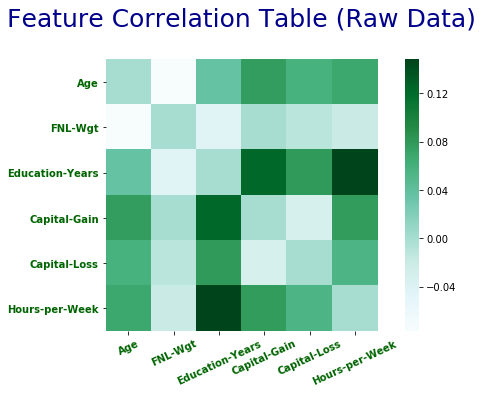

In [8]:
# Feature Correlation Analysis
_ = plt.figure(figsize = (10,5))
_ = plt.title('Feature Correlation Table (Raw Data)\n', size = 25, color = 'darkblue')
_ = sns.heatmap(IncomeCorr, square=True, cmap='BuGn')
_ = plt.xticks(rotation = 25, color = 'darkgreen', fontweight = 'bold')
_ = plt.yticks(color = 'darkgreen', fontweight = 'bold')
_ = plt.show()

In [9]:
gender = round(pd.crosstab(adultIncome_df.Gender, \
                           adultIncome_df.Income50K).div(pd.crosstab(adultIncome_df.Gender, \
                                                                     adultIncome_df.Income50K).apply(sum,1),
                                                         0),\
               2) *100

gender.sort_values(by = '>50K', inplace = True)

<ul></ul> <center> $ \color{darkblue} {\Large { \textit {Income and Gender} } }  $

Gender,Female,Male
Income50K,,
<=50K,89.0,69.0
>50K,11.0,31.0


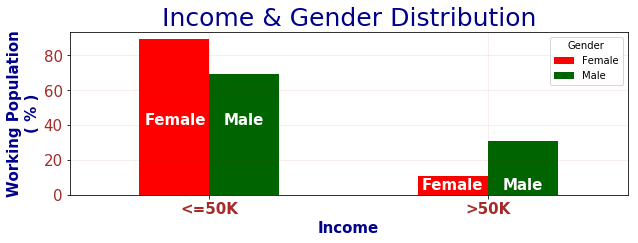

$ \color {darkblue} { \textrm {This data and plot indicates a clear income inequality} \
\textrm {between male and female individual earnings. } } \\ $

In [10]:
display(Markdown(r'<ul></ul> <center> $ \color{darkblue} {\Large { \textit {Income and Gender} } }  $'))
display(gender.T)
# use transpose for side by side gender plot
_ = gender.T.plot(kind ='bar', color = ['r','darkgreen'], figsize = (10,3))
_ = plt.title('Income & Gender Distribution', size = 25, color = 'darkblue')
_ = plt.xlabel('Income', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.ylabel('Working Population\n( % )', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.xticks(rotation =0, color = 'brown', size = 15, fontweight = 'bold')
_ = plt.yticks(color = 'brown', size = 15)
_ = plt.text(-0.23, 40, 'Female', size = 15, color='w', fontweight = 'bold')
_ = plt.text(0.05, 40, 'Male', size = 15, color='w', fontweight = 'bold')
_ = plt.text(0.76, 3, 'Female', size = 15, color='w', fontweight = 'bold')
_ = plt.text(1.05, 3, 'Male', size = 15, color='w', fontweight = 'bold')
_ = plt.grid(alpha = 0.1, color = 'brown')
_ = plt.show()
display(Markdown(r'$ \color {darkblue} { \textrm {This data and plot indicates a clear income inequality} \
\textrm {between male and female individual earnings. } } \\ $'))

<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Race} } }  $

$ \color{darkblue} { \textrm {Here, data and plot reveal highest income earners have identified } \
\textrm {themselfs as White and Asian.} \
\\ \textrm {For remaining races, income earnings exceeding \$50K are below 12% of their working population.} } \\ $

Race,Other,Amer-Indian-Eskimo,Black,White,Asian-Pac-Islander
Income50K,,,,,
<=50K,91.0,88.0,88.0,74.0,73.0
>50K,9.0,12.0,12.0,26.0,27.0


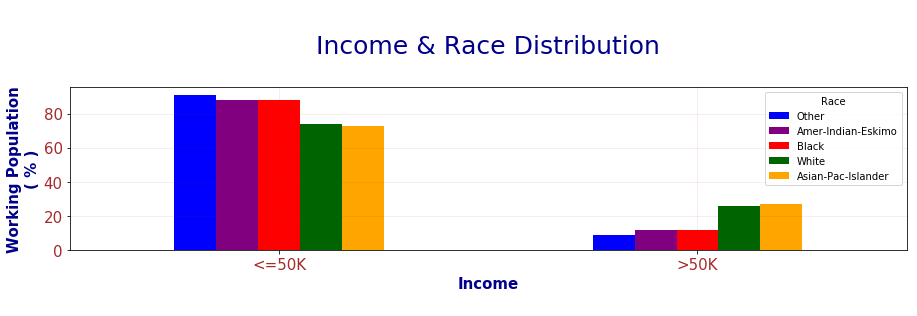

In [11]:
race = round(pd.crosstab(adultIncome_df.Race, \
                           adultIncome_df.Income50K).div(pd.crosstab(adultIncome_df.Race, \
                                                                     adultIncome_df.Income50K).apply(sum,1),
                                                         0),\
               2) *100

race.sort_values(by = '>50K', inplace = True)
display(Markdown(r'<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Race} } }  $'))
display(Markdown(r'$ \color{darkblue} { \textrm {Here, data and plot reveal highest income earners have identified } \
\textrm {themselfs as White and Asian.} \
\\ \textrm {For remaining races, income earnings exceeding \$50K are below 12% of their working population.} } \\ $'))
display(race.T)
_ = race.T.plot(kind ='bar', color = ['b','purple','r','darkgreen','orange'], figsize = (15,3))
_ = plt.title('\nIncome & Race Distribution\n', size = 25, color = 'darkblue')
_ = plt.xlabel('Income\n', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.ylabel('Working Population\n( % )', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.xticks(rotation = 0, color = 'brown', size = 15)
_ = plt.yticks(color = 'brown', size = 15)
_ = plt.grid(alpha = 0.1, color = 'brown')

<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Education} } }  $

$ \color {darkblue} { \textrm {This data and plot indicates direct proportionality of income} \
\textrm {to education. As years of education increases, individual } \\ \textrm {earnings converges to exceed \$50K. } } \\ $

Education-Years,1,2,3,5,7,4,6,8,9,10,12,11,13,14,15,16
Income50K,,,,,,,,,,,,,,,,
<=50K,100.0,96.0,95.0,95.0,95.0,94.0,93.0,92.0,84.0,81.0,75.0,74.0,59.0,44.0,27.0,26.0
>50K,0.0,4.0,5.0,5.0,5.0,6.0,7.0,8.0,16.0,19.0,25.0,26.0,41.0,56.0,73.0,74.0


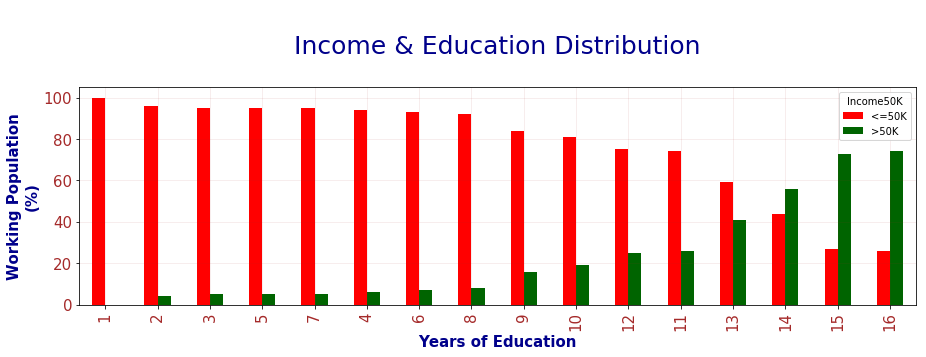

In [12]:
edu = round(pd.crosstab(adultIncome_df['Education-Years'], \
                           adultIncome_df.Income50K).div(pd.crosstab(adultIncome_df['Education-Years'], \
                                                                     adultIncome_df.Income50K).apply(sum,1),
                                                         0),\
               2) *100

edu.sort_values(by = '>50K', inplace = True)
display(Markdown(r'<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Education} } }  $'))
display(Markdown(r'$ \color {darkblue} { \textrm {This data and plot indicates direct proportionality of income} \
\textrm {to education. As years of education increases, individual } \\ \textrm {earnings converges to exceed \$50K. } } \\ $'))
display(edu.T)
_ = edu.plot(kind ='bar', color = ['r','darkgreen'], figsize = (15,4))
_ = plt.title('\nIncome & Education Distribution\n', size = 25, color = 'darkblue')
_ = plt.xlabel('Years of Education', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.ylabel('Working Population\n(%)', size = 15, color = 'darkblue', fontweight = 'bold')
_ = plt.xticks(color = 'brown', size = 15)
_ = plt.yticks(color = 'brown', size = 15)
_ = plt.grid(alpha = 0.1, color = 'brown')

<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Age} } }  $

$ \color {darkblue} { \textrm {Middle-age indicates higheset individual income.} \
\\ \textrm {Most individuals between ages of 35 and 62 years appear to have highest income exceeding \$50K. } } \\ $

Age,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,90
Income50K,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
<=50K,100.0,100.0,100.0,100.0,100.0,98.0,99.0,96.0,94.0,92.0,90.0,86.0,84.0,80.0,79.0,77.0,78.0,73.0,75.0,71.0,66.0,66.0,66.0,66.0,65.0,65.0,65.0,61.0,61.0,60.0,59.0,60.0,64.0,57.0,59.0,60.0,59.0,58.0,65.0,68.0,63.0,67.0,63.0,68.0,68.0,74.0,74.0,75.0,76.0,77.0,75.0,78.0,81.0,79.0,78.0,87.0,84.0,76.0,84.0,89.0,83.0,78.0,59.0,91.0,85.0,100.0,67.0,90.0,100.0,100.0,100.0,100.0,81.0
>50K,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,6.0,8.0,10.0,14.0,16.0,20.0,21.0,23.0,22.0,27.0,25.0,29.0,34.0,34.0,34.0,34.0,35.0,35.0,35.0,39.0,39.0,40.0,41.0,40.0,36.0,43.0,41.0,40.0,41.0,42.0,35.0,32.0,37.0,33.0,37.0,32.0,32.0,26.0,26.0,25.0,24.0,23.0,25.0,22.0,19.0,21.0,22.0,13.0,16.0,24.0,16.0,11.0,17.0,22.0,41.0,9.0,15.0,0.0,33.0,10.0,0.0,0.0,0.0,0.0,19.0


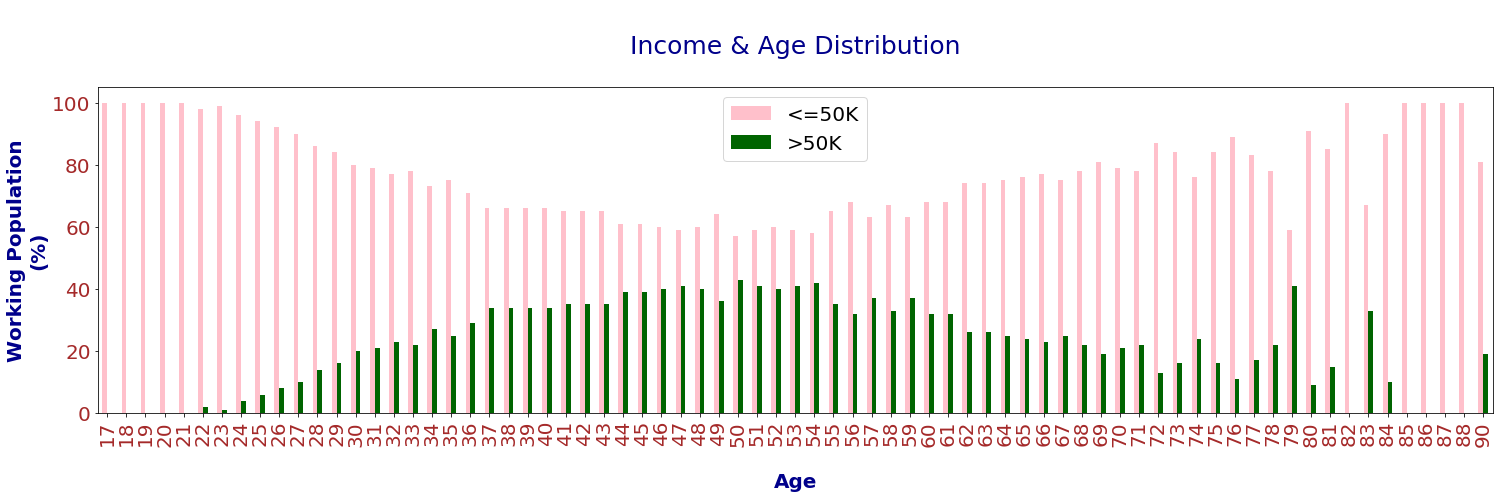

In [13]:
age = round(pd.crosstab(adultIncome_df.Age, \
                           adultIncome_df.Income50K).div(pd.crosstab(adultIncome_df.Age, \
                                                                     adultIncome_df.Income50K).apply(sum,1),
                                                         0),\
               2) *100
display(Markdown(r'<ul></ul><center> $ \color{darkblue} {\Large { \textit {Income and Age} } }  $'))
display(Markdown(r'$ \color {darkblue} { \textrm {Middle-age indicates higheset individual income.} \
\\ \textrm {Most individuals between ages of 35 and 62 years appear to have highest income exceeding \$50K. } } \\ $'))
display(age.T)
_ = age.plot(kind ='bar', color = ['pink','darkgreen'], figsize = (25, 6))
_ = plt.title('\nIncome & Age Distribution\n', size = 25, color = 'darkblue')
_ = plt.xlabel('\nAge', size = 20, color = 'darkblue', fontweight = 'bold')
_ = plt.ylabel('Working Population\n(%)', size = 20, color = 'darkblue', fontweight = 'bold')
_ = plt.xticks(color = 'brown', size = 20)
_ = plt.yticks(color = 'brown', size = 20)
_ = plt.legend(prop={'size': 20})

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Data Wrangling} $

***
</span>
</div>

### <span style='color:darkblue'> $ \textrm {Replace '?' with 'Other' and Remove Space Characters} $ </span>

In [14]:
# Replce category name'?' with 'Other'
for col in adultIncome_df.columns:
    if adultIncome_df[col].dtype == 'object':
        adultIncome_df[col]= (adultIncome_df[col].str.strip()).str.replace('?', col+'-Other')

### <span style='color:darkblue'> $ \textrm {Convert Features with Categorical Data to Binary Values} $ </span>

In [15]:
# avoid error if column already removed
if 'Education' in adultIncome_df.columns:
    # remove column 'Education' since it is represented by 'Education-Years'
    adultIncome_df.drop(['Education'], axis = 1, inplace=True)

In [16]:
# Create categorical dummies for binary columns
for col in adultIncome_df.columns:
    # skip over columns with numeric data
    if pd.api.types.is_numeric_dtype(adultIncome_df[col].dtype) == False:  
        # get dummies for each category drop first category to avoid overfitting
        dummies = pd.get_dummies(adultIncome_df[[col]], prefix_sep='_', drop_first = True)
        
        for dcol in dummies.columns:
            # convert to 'category type'
            dm_cat = dummies[dcol].astype('category')
            # insert new columns in the original data frame for analysis
            adultIncome_df.insert(adultIncome_df.columns.get_loc(col), dcol, dm_cat.values)
    
        # remove category column from dataFrame
        adultIncome_df.drop([col], axis=1, inplace=True)

### <span style = 'color:darkblue'> $ \textrm {Pre-Process Training and Test data} $

In [17]:
# decimal places for rounding numbers
decimals = 2

# Feature columns - remove target columns from column list
feature_column_names = [c for c in adultIncome_df.columns if c!='Income50K_>50K']
target_column_name = 'Income50K_>50K'

# Use all features
X_data = adultIncome_df[feature_column_names] 
Y_data = adultIncome_df[[target_column_name]] 

# split data for training and test
X_train_data, X_test_data, Y_train_data, Y_test_data = train_test_split(X_data, \
                                                                        Y_data, \
                                                                        test_size = 0.0017, \
                                                                        random_state = 42)
SampleSize = X_test_data.shape[0]
print('SampleSize:     %d' % SampleSize)
featureCount = len(adultIncome_df.columns) - 1
print('Feature Count :', featureCount)

SampleSize:     56
Feature Count : 85


<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Exploratory Data Analysis (Continued)} $

***
</span>
</div>

### <span style = 'color:darkblue'> $ \textrm {Correlation of Features with Categorical Data Converted to Binary Values} $

In [18]:
corrLst = []
corrHiVal = pd.DataFrame()
trainData = pd.get_dummies(X_train_data, drop_first = True).corr()

trainData = zeroDiagonal(trainData)
# Check diagonal values
trainData.head(3)

,Age,FNL-Wgt,Education-Years,Capital-Gain,Capital-Loss,Hours-per-Week,Workclass_Local-gov_1,Workclass_Never-worked_1,Workclass_Private_1,Workclass_Self-emp-inc_1,Workclass_Self-emp-not-inc_1,Workclass_State-gov_1,Workclass_Without-pay_1,Workclass_Workclass-Other_1,Marital Status_Married-AF-spouse_1,Marital Status_Married-civ-spouse_1,Marital Status_Married-spouse-absent_1,Marital Status_Never-married_1,Marital Status_Separated_1,Marital Status_Widowed_1,Occupation_Armed-Forces_1,Occupation_Craft-repair_1,Occupation_Exec-managerial_1,Occupation_Farming-fishing_1,Occupation_Handlers-cleaners_1,Occupation_Machine-op-inspct_1,Occupation_Occupation-Other_1,Occupation_Other-service_1,Occupation_Priv-house-serv_1,Occupation_Prof-specialty_1,Occupation_Protective-serv_1,Occupation_Sales_1,Occupation_Tech-support_1,Occupation_Transport-moving_1,Relationship_Not-in-family_1,Relationship_Other-relative_1,Relationship_Own-child_1,Relationship_Unmarried_1,Relationship_Wife_1,Race_Asian-Pac-Islander_1,Race_Black_1,Race_Other_1,Race_White_1,Gender_Male_1,Citizenship_Canada_1,Citizenship_China_1,Citizenship_Citizenship-Other_1,Citizenship_Columbia_1,Citizenship_Cuba_1,Citizenship_Dominican-Republic_1,Citizenship_Ecuador_1,Citizenship_El-Salvador_1,Citizenship_England_1,Citizenship_France_1,Citizenship_Germany_1,Citizenship_Greece_1,Citizenship_Guatemala_1,Citizenship_Haiti_1,Citizenship_Holand-Netherlands_1,Citizenship_Honduras_1,Citizenship_Hong_1,Citizenship_Hungary_1,Citizenship_India_1,Citizenship_Iran_1,Citizenship_Ireland_1,Citizenship_Italy_1,Citizenship_Jamaica_1,Citizenship_Japan_1,Citizenship_Laos_1,Citizenship_Mexico_1,Citizenship_Nicaragua_1,Citizenship_Outlying-US(Guam-USVI-etc)_1,Citizenship_Peru_1,Citizenship_Philippines_1,Citizenship_Poland_1,Citizenship_Portugal_1,Citizenship_Puerto-Rico_1,Citizenship_Scotland_1,Citizenship_South_1,Citizenship_Taiwan_1,Citizenship_Thailand_1,Citizenship_Trinadad&Tobago_1,Citizenship_United-States_1,Citizenship_Vietnam_1,Citizenship_Yugoslavia_1
Age,0.000000,-0.076289,0.036802,0.077538,0.057929,0.068689,0.060978,-0.019376,-0.198655,0.102613,0.136395,0.012797,0.014005,0.042617,-0.011905,0.315605,0.016711,-0.534452,0.010488,0.264915,-0.010198,0.012379,0.099756,0.034236,-0.098669,-0.016262,0.041310,-0.089560,0.015679,0.054221,0.003822,-0.032031,-0.019590,0.026803,-0.009826,-0.070146,-0.432991,0.043020,0.020816,-0.011118,-0.019467,-0.034387,0.033405,0.088640,0.017761,0.013930,0.001607,0.003533,0.028522,-0.002905,-0.004173,-0.018204,0.009942,0.000841,0.003214,0.016703,-0.020055,-0.000833,-0.002676,-0.006943,-0.008970,0.015840,-0.002002,0.002233,-0.004231,0.027276,-0.010951,-0.001088,-0.006659,-0.055159,-0.011774,0.000202,-0.007527,0.004952,0.014296,0.004246,0.007865,0.002585,0.000613,-0.013826,-0.006276,0.004847,0.015875,-0.015064,0.000376
FNL-Wgt,-0.076289,0.000000,-0.043282,0.000866,-0.010252,-0.018732,-0.002901,0.005033,0.043025,-0.024595,-0.039177,-0.010576,-0.003052,-0.002940,-0.000409,-0.026076,0.003625,0.036713,0.028723,-0.025933,0.004041,0.008567,-0.018907,-0.032971,0.028906,0.012556,-0.002616,-0.003730,0.007753,-0.016346,0.016987,0.003497,0.003751,0.001354,0.007234,0.025711,0.013750,0.004385,-0.016610,-0.051375,0.117908,0.006830,-0.056831,0.026859,-0.005753,-0.004893,0.004528,0.014283,0.028976,0.001013,-0.001093,0.035196,-0.003700,0.000640,-0.000285,-0.013112,0.031711,0.006706,-0.008506,0.012467,0.007654,-0.001762,-0.011181,-0.002612,-0.013335,-0.003641,0.010589,-0.001691,0.004753,0.134053,0.032117,0.002890,0.024809,-0.017555,-0.002397,-0.013163,0.007165,-0.003794,-0.012377,-0.001257,-0.001253,0.005274,-0.075121,-0.011410,0.005502
Education-Years,0.036802,-0.043282,0.000000,0.122355,0.079855,0.148043,0.098083,-0.015131,-0.118536,0.077242,0.016281,0.102890,-0.008144,-0.077849,0.000964,0.086447,-0.034256,-0.032525,-0.054857,-0.067819,0.000197,-0.142951,0.200750,-0.101631,-0.128039,-0.158644,-0.078671,-0.169622,-0.071982,0.419386,0.005546,0.030348,0.060756,-0.116134,0.053145,-0.088723,-0.0991

In [19]:
trainData = zeroDiagonal(trainData)
# Use matric upper triangle with values >= 0.5
for i in range(trainData.shape[0]):
    for j in range(i,trainData.shape[1]):
        if np.abs(trainData.iloc[i][j]) >= 0.5:
            corrLst.append([np.round(trainData.iloc[i][j], 4), \
                            trainData.index[i], trainData.columns[j]])
            corrHiVal = corrHiVal.append(corrLst)
            
corrHiVal.columns = ['Correlation Value', 'Feature', 'Feature Covariant']
# Remove duplicates and sort by values
corrHiVal = corrHiVal.drop_duplicates().sort_values(by = ['Correlation Value'], ascending = False)
_ = corrHiVal.set_index('Feature')

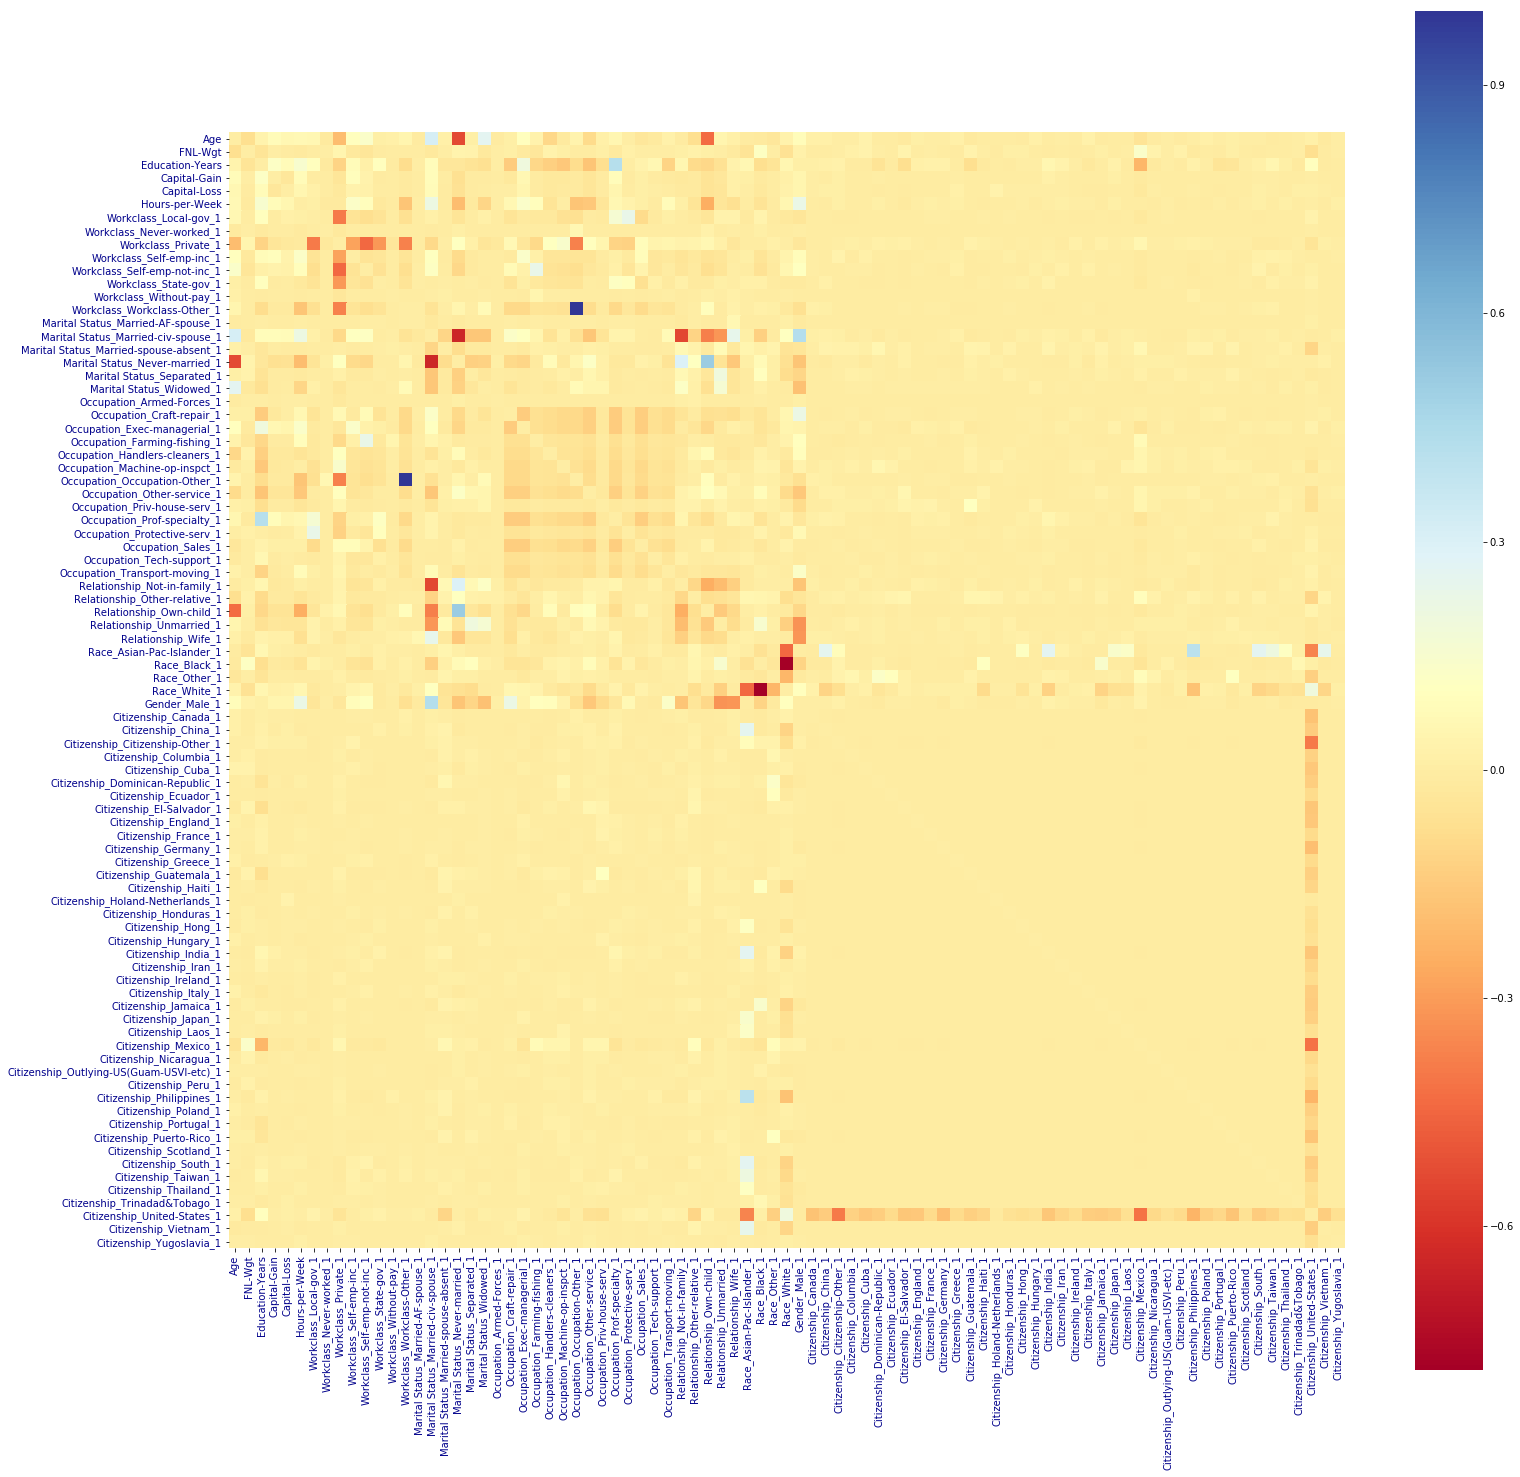

$ \color {darkblue} {\textrm {Feature correlation reveals highly correlated features which may lead to overfitting.}} $

,Correlation Value,Feature,Feature Covariant
1,0.9980,Workclass_Workclass-Other_1,Occupation_Occupation-Other_1
4,0.5097,Marital Status_Never-married_1,Relationship_Own-child_1
0,-0.5345,Age,Marital Status_Never-married_1
3,-0.5376,Marital Status_Married-civ-spouse_1,Relationship_Not-in-family_1
2,-0.6451,Marital Status_Married-civ-spouse_1,Marital Status_Never-married_1
5,-0.7887,Race_Black_1,Race_White_1


In [20]:
_ = plt.figure(figsize = (25,25))
# Binary Feature Correlation Analysis
_ = sns.heatmap(trainData, square = True, cmap='RdYlBu')
_ = plt.xticks(color = 'darkblue')
_ = plt.yticks(color = 'darkblue')
_ = plt.show()
display(Markdown(r'$ \color {darkblue} {\textrm {Feature correlation reveals highly correlated features which may lead to overfitting.}} $'))
display(corrHiVal)

$ \color {darkblue} {\textrm {Translating all feature correlation on the positive scale provides important information for considering feature reduction.}} $

$ \color {darkblue} {\textrm {Some of the high correlation here such as Occupation-Other and Workclass-Other indicate candidates for}} $

$ \color {darkblue} {\textrm {feature reduction as the descriptions imply. Similarly correlation od 0.79 between Race_Black and Race_White offer opportunity}} $

$ \color {darkblue} {\textrm {for feature reduction.}} $

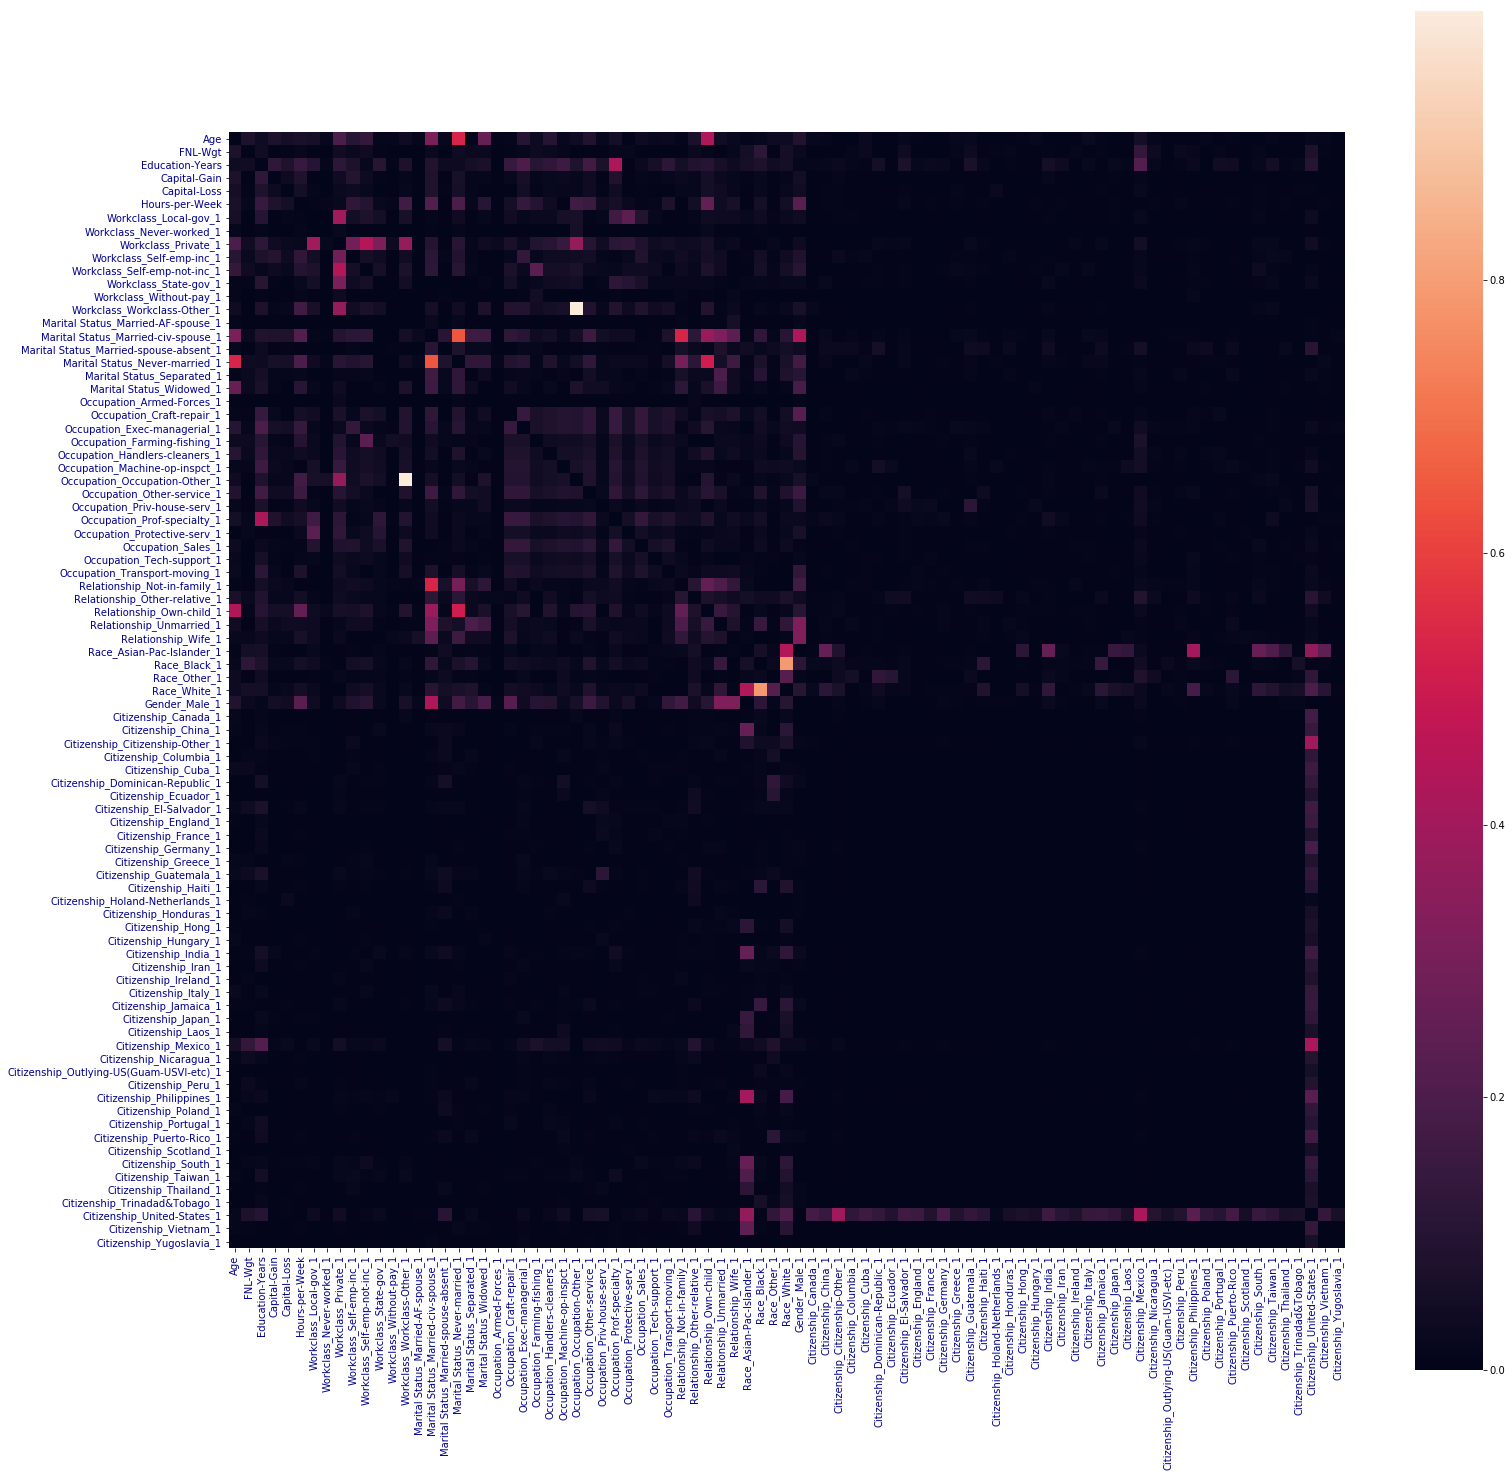

In [21]:
trainDataAbs = pd.get_dummies(X_train_data, drop_first = True).corr().abs()
trainDataAbs = zeroDiagonal(trainDataAbs)
print('\n')
display(Markdown(r'$ \color {darkblue} {\textrm {Translating all feature correlation on the positive scale provides important information for considering feature reduction.}} $'))
display(Markdown(r'$ \color {darkblue} {\textrm {Some of the high correlation here such as Occupation-Other and Workclass-Other indicate candidates for}} $'))
display(Markdown(r'$ \color {darkblue} {\textrm {feature reduction as the descriptions imply. Similarly correlation od 0.79 between Race_Black and Race_White offer opportunity}} $'))
display(Markdown(r'$ \color {darkblue} {\textrm {for feature reduction.}} $'))
_ = plt.figure(figsize = (25,25))
# Binary Feature Correlation Analysis
_ = sns.heatmap(trainDataAbs, square = True)
_ = plt.xticks(color = 'darkblue')
_ = plt.yticks(color = 'darkblue')
_ = plt.show()
print('\n')

$ \color{darkblue} {\large {\textrm {Exploring Categorical Features Related to Target with } }} \color{darkred} {\Large \chi2 } $

In [22]:
#from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
#from sklearn.feature_selection import RFECV

In [23]:
# Copy categorical features for Chi2 analysis
cat_trainData = X_test_data.copy()
# Remove numerical features and tabulate categorical features
cat_trainData.drop(['Age', 'FNL-Wgt', 'Education-Years', \
                    'Capital-Gain', 'Capital-Loss', 'Hours-per-Week'], \
                   axis = 1, inplace = True)

$\color{darkblue} {\textrm {Features with best } {\bf\;\chi2\;} \textrm {statistics are considered most relevant to adult income.}} $

$\color{darkblue} {\textrm {From the calculations, about 35 features out of 85 have none-negative statistics. With married marital status on top of the list.}} $

,$\color{darkred} {\large \;\chi2} \large {\textrm {-Statistics }} $,${\large \textrm {P-Value}} $
Marital Status_Married-civ-spouse,15.233999,0.000095
Occupation_Craft-repair,4.741463,0.029444
Gender_Male,4.115349,0.042496
Relationship_Not-in-family,3.787757,0.051629
Marital Status_Never-married,3.787757,0.051629
Relationship_Unmarried,3.292683,0.069589
Citizenship_Puerto-Rico,2.733333,0.098274
Relationship_Own-child,2.560976,0.109531
Occupation_Sales,1.829268,0.176214
Occupation_Machine-op-inspct,1.463415,0.226388


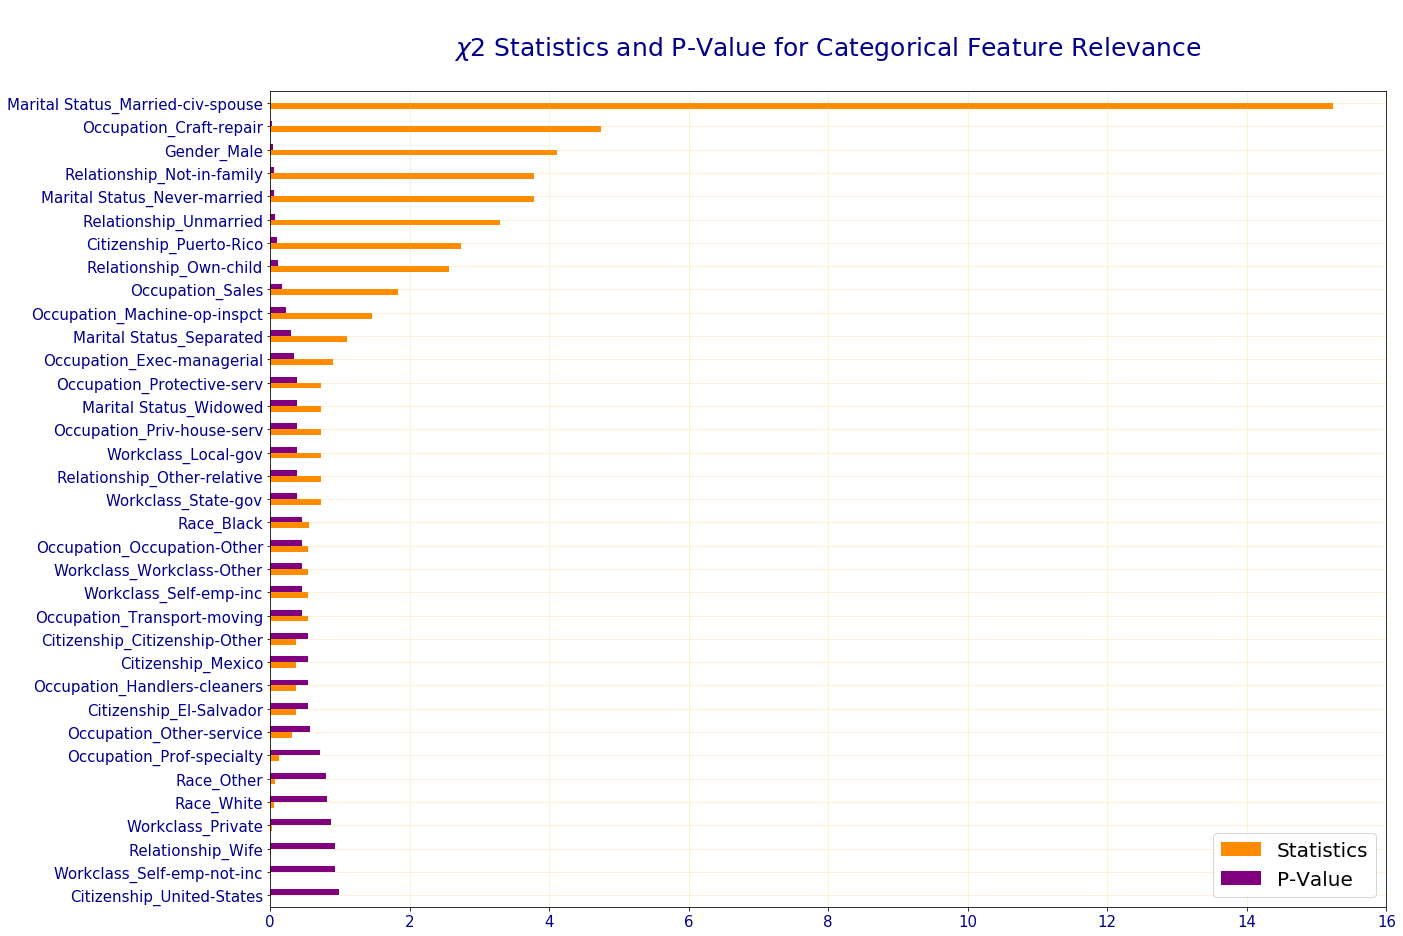

Level,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Name,Preschool,1st-4th,5th-6th,7th-8th,9th,10th,11th,12th,HS-grad,Some-college,Assoc-voc,Assoc-acdm,Bachelors,Masters,Prof-school,Doctorate


In [24]:
# Apply chi2 on categorical features
chi2_stat, chi2_P_value = chi2(cat_trainData, Y_test_data)

# Tabulate Chi2 , drop null values and sort features with highest statistics 
chi2_featureStat = pd.DataFrame(np.transpose([chi2_stat, chi2_P_value]), \
                                index = cat_trainData.columns, \
                                columns = [r'$\color{darkred} {\large \;\chi2} \large {\textrm {-Statistics }} $', \
                                           r'${\large \textrm {P-Value}} $']).dropna().sort_values(by = r'$\color{darkred} {\large \;\chi2} \large {\textrm {-Statistics }} $',\
                                                                                                                                       ascending = False)
print('\n')
display(Markdown(r'$\color{darkblue} {\textrm {Features with best } {\bf\;\chi2\;} \textrm {statistics are considered most relevant to adult income.}} $'))
display(Markdown(r'$\color{darkblue} {\textrm {From the calculations, about 35 features out of 85 have none-negative statistics. With married marital status on top of the list.}} $'))
display(chi2_featureStat[0:15])

chi2_featStat = pd.DataFrame(np.transpose([chi2_stat, chi2_P_value]), \
                                index = cat_trainData.columns, \
                                columns = ['Statistics', 'P-Value']).dropna().sort_values(by='P-Value', ascending = False)
#_ = chi2_featStat.iloc[:,0].plot.bar(figsize = (20,10), color = 'darkorange')
_ = chi2_featStat.plot.barh(figsize = (20,15), color = ['darkorange','purple'])
_ = plt.title('\n$\chi2 $ Statistics and P-Value for Categorical Feature Relevance\n', size = 25, color = 'darkblue')
_ = plt.grid(color = 'orange', alpha = 0.2)
_ = plt.xticks(color = 'darkblue', size = 15)
_ = plt.yticks(color = 'darkblue', size = 15)
_ = plt.legend(prop={'size': 20})
_ = plt.show()
display(eduRef)
print('\n')

$ \color{darkblue} {\large {\textrm {Identifying Numerical Features Related to Target with  } } \; \color{darkred} {\textrm F-Statistics }  } $

In [25]:
v_trainData = X_test_data.loc[:, ('Age', 'FNL-Wgt', 'Education-Years', \
                                  'Capital-Gain', 'Capital-Loss', 'Hours-per-Week')]

,$\color{darkred} {\large {\textrm {F-Statistics}}} $,$\color{darkred} {\large {\textrm {P-Value}}} $
Hours-per-Week,6.272639,0.015313
Age,5.337293,0.024723
Capital-Gain,5.026237,0.029096
FNL-Wgt,3.609167,0.062808
Capital-Loss,2.823980,0.098642
Education-Years,0.341869,0.561188


$\color{darkblue} {\textrm {Numeric features with best F-Statistics are considered most relevant to predicting the target.}} $

$\color{darkblue} {\textrm {From the calculations, all six features have positive statistics, with Hours-per-Week, Age, and Capital-Gain on top of the list.}} $

$\color{darkblue} {\textrm {Although intuitively, Education-Years should be significant for income level, the F-statistic < 1, does not appear to}} $

$\color{darkblue} {\textrm {show evidence for education to be statistically related to the target, adult income. }} $

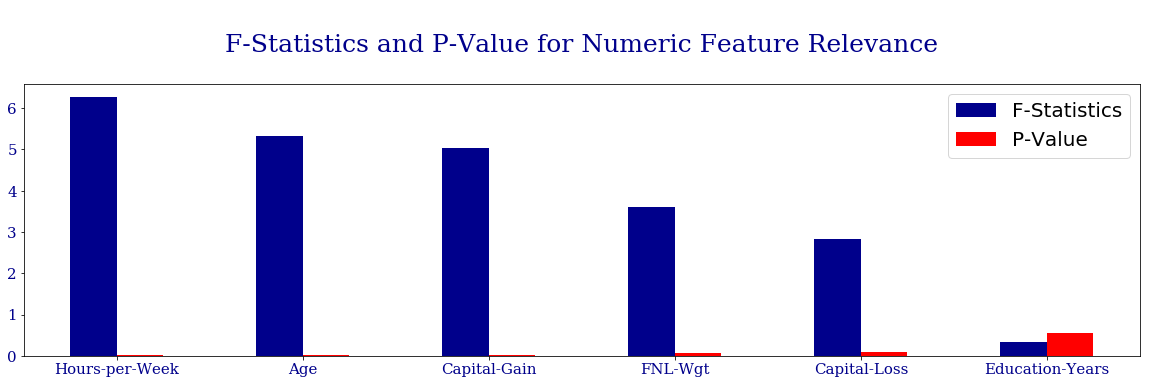

In [26]:
# Apply f-classification  to calculate F-statistics and associated p-value
f_stat, f_P_value = f_classif(v_trainData, np.array(Y_test_data)[:,0])
# Format DataFrame table of features with F-stat and p-value
f_featureStat = pd.DataFrame(np.transpose([f_stat, f_P_value]), \
                             index = v_trainData.columns, \
                             columns = [r'$\color{darkred} {\large {\textrm {F-Statistics}}} $', \
                                        r'$\color{darkred} {\large {\textrm {P-Value}}} $']).sort_values(by = r'$\color{darkred} {\large {\textrm {F-Statistics}}} $', \
                                                                                                        ascending = False)
display(f_featureStat)
f_featStat = pd.DataFrame(np.transpose([f_stat, f_P_value]), \
                          index = v_trainData.columns, \
                          columns = ['F-Statistics', 'P-Value']).sort_values(by = 'F-Statistics', \
                                                                             ascending = False)
_ = f_featStat.plot.bar(figsize = (20,5), color = ['darkblue', 'red'])
print('\n')
display(Markdown(r'$\color{darkblue} {\textrm {Numeric features with best F-Statistics are considered most relevant to predicting the target.}} $'))
display(Markdown(r'$\color{darkblue} {\textrm {From the calculations, all six features have positive statistics, with Hours-per-Week, Age, and Capital-Gain on top of the list.}} $'))
display(Markdown(r'$\color{darkblue} {\textrm {Although intuitively, Education-Years should be significant for income level, the F-statistic < 1, does not appear to}} $'))
display(Markdown(r'$\color{darkblue} {\textrm {show evidence for education to be statistically related to the target, adult income. }} $'))

_ = plt.title('\nF-Statistics and P-Value for Numeric Feature Relevance\n', \
              size = 25, \
              color = 'darkblue', \
              fontname = 'serif')
_ = plt.xticks(rotation = 0, color = 'darkblue', size = 15, fontname = 'serif')
_ = plt.yticks(color = 'darkblue', size = 15, fontname = 'serif')
_ = plt.legend(prop={'size': 20})

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Investigating Education's Low Relevence to Predicting Income} $

***
</span>
</div>

,Citizenship
United-States,90
Mexico,2


<center>$ \color{darkblue} {\textbf {Most observations are from United States citizens representing 90% of observed population} } $

<center>$ \color{darkred} {\textbf {Second largest observations are from Mexican citizens representing 2% of observed population} } $

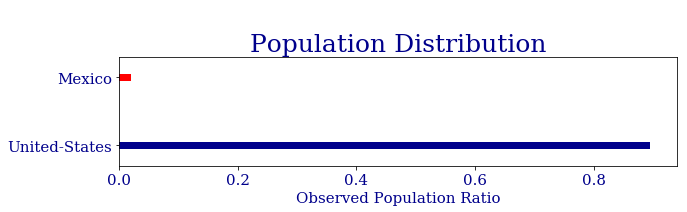

In [27]:
# Calculate percent representation of top two nations represented 
Citizenship = Income_df.Citizenship.value_counts() / Income_df.shape[0]
display(pd.DataFrame(round(Citizenship[0:2],2)*100).astype(int), \
        Markdown(r'<center>$ \color{darkblue} {\textbf {Most observations are from United States citizens representing 90% of observed population} } $'), \
        Markdown(r'<center>$ \color{darkred} {\textbf {Second largest observations are from Mexican citizens representing 2% of observed population} } $'))
_ = Citizenship[0:2].plot(kind = 'barh', color = ['darkblue', 'red'], figsize=(10,2), width = 0.1)
_ = plt.title('\nPopulation Distribution', size = 25, fontname = 'serif', color = 'darkblue')
_ = plt.xticks(rotation = 0, size = 15, color = 'darkblue', fontname = 'serif')
_ = plt.xlabel('Observed Population Ratio', size = 15, color = 'darkblue', fontname = 'serif')
_ = plt.yticks(size = 15, color = 'darkblue', fontname = 'serif')


$ \color{darkblue} {\large {\textrm {Investigating Correlation between 'Education-Years' and other Featurs } } } $

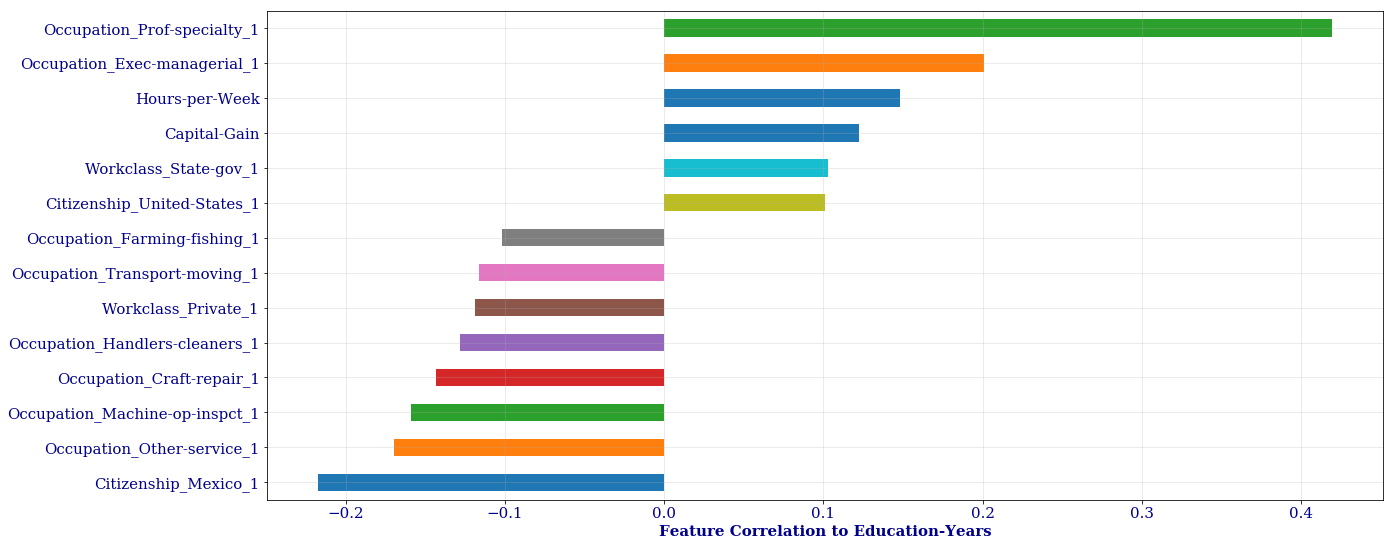

$ \color {darkblue} {\large\textrm {Correlation Table}} $

,Education-Years
Occupation_Prof-specialty_1,0.419386
Occupation_Exec-managerial_1,0.200750
Hours-per-Week,0.148043
Capital-Gain,0.122355
Workclass_State-gov_1,0.102890
Citizenship_United-States_1,0.101043
Occupation_Farming-fishing_1,-0.101631
Occupation_Transport-moving_1,-0.116134
Workclass_Private_1,-0.118536
Occupation_Handlers-cleaners_1,-0.128039


$ \color {darkblue} {\textrm {From the correlation matrix, the Occupation_Prof-specialty is most positively correlated to the Education-Years.}} $

$ \color {darkblue} {\textrm {Practical occupations such as fishing, farming, and service providers are negatively correlated to the Education-Years.}} $

In [28]:
edu = trainData['Education-Years']
edu_ordered = edu[np.abs(edu.values)>0.1].sort_values(ascending = True)
_ = edu_ordered.plot.barh(figsize = (20,9))
_ = plt.xticks(size = 15, color = 'darkblue', fontname = 'serif')
_ = plt.xlabel('Feature Correlation to Education-Years', size = 15, color = 'darkblue', fontname = 'serif', fontweight = 'bold')
_ = plt.yticks(size = 15, color = 'darkblue', fontname = 'serif')
_ = plt.grid(alpha = 0.3)
_ = plt.show()
edu_ordered = edu[np.abs(edu.values)>0.1].sort_values(ascending = False)
display(Markdown(r'$ \color {darkblue} {\large\textrm {Correlation Table}} $'))
display(pd.DataFrame(edu_ordered))
print('\n')
display(Markdown(r'$ \color {darkblue} {\textrm {From the correlation matrix, the Occupation_Prof-specialty is most positively correlated to the Education-Years.}} $'))
display(Markdown(r'$ \color {darkblue} {\textrm {Practical occupations such as fishing, farming, and service providers are negatively correlated to the Education-Years.}} $'))
print('\n')

$ \color{darkblue} {\large {\textrm {US Citizen Education Data } } } $

In [29]:
# Filter data and summarize Education of US citizens in respect to their income level
eduIncomeUSA = (pd.crosstab(Income_df['Education-Years'], [Income_df.Citizenship, \
                                                           Income_df.Income50K]))['United-States']
# Filter data and caculate US citizen total income observations for each category of Income50K (>50K  and  <=50K)
incomeUSA = pd.DataFrame((pd.crosstab(Income_df.Citizenship, Income_df.Income50K)).T['United-States']).T

In [30]:
# Filter data for view education of US citizens in respect to their occupation and income level
eduOccupIncomeUSA = (pd.crosstab(Income_df['Education-Years'], [Income_df.Citizenship, \
                                                                Income_df.Occupation, \
                                                                Income_df.Income50K]))['United-States']
eduOccIncUSA = eduOccupIncomeUSA.T.sort_values(by = 'Income50K', ascending = False).copy()

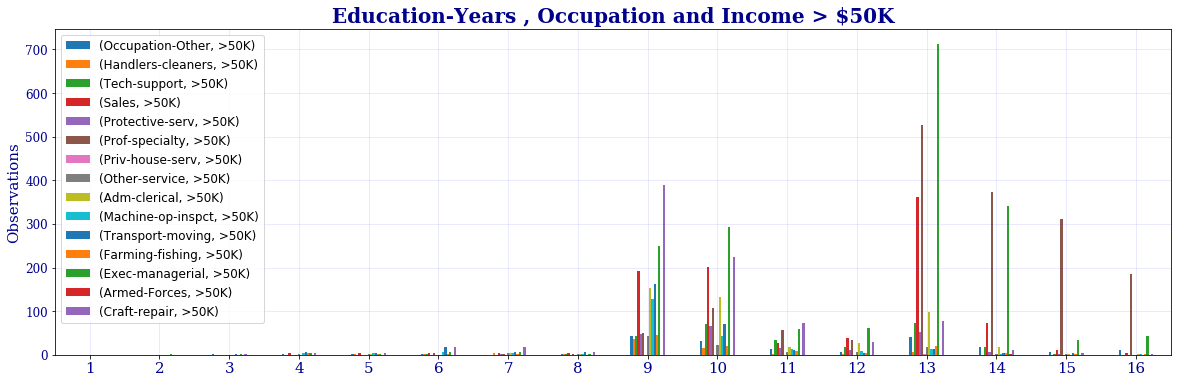

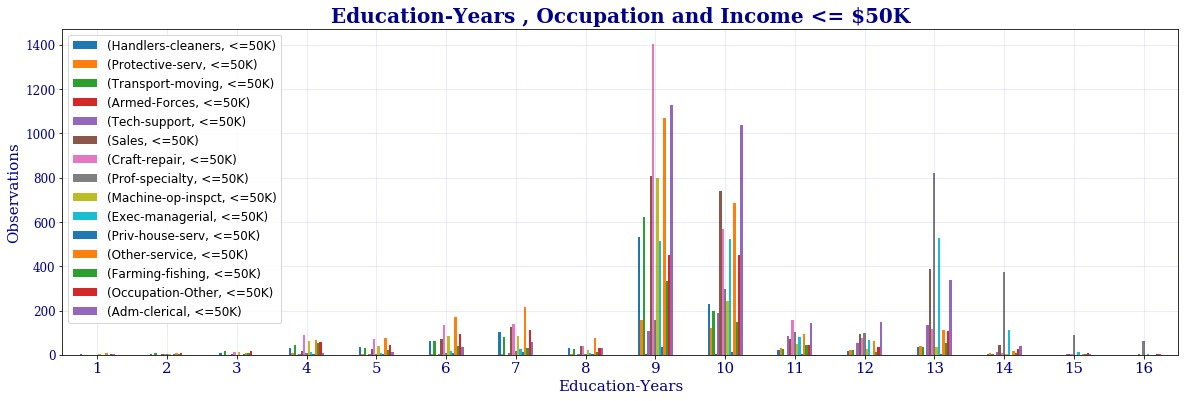

Level,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Name,Preschool,1st-4th,5th-6th,7th-8th,9th,10th,11th,12th,HS-grad,Some-college,Assoc-voc,Assoc-acdm,Bachelors,Masters,Prof-school,Doctorate


$\color{darkblue} {\textbf{For income level > \$50K, education level 13 (Bachelors Degree) has most observations (712 individuals)}}$

$\color{darkblue} {\textbf{holding Exec-managerial positions, followed by 390 High School grads holding Craft-repair positions.} }$

Education-Years,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Income50K,,,,,,,,,,,,,,,,
<=50K,6,9,17,89,76,171,215,75,1403,1040,157,147,823,374,91,63
>50K,0,1,2,7,5,18,17,7,390,293,72,62,712,374,312,185


In [31]:
eduOccupIncomeUSAhi = eduOccIncUSA[0:15].copy()
eduOccupIncomeUSAlo = eduOccIncUSA[15:30].copy()
print('\n')
#display(Markdown(r'<center>$\color{darkblue} {\large \textbf{Education of US citizens in respect to their occupation and income level}}$'), \
#        eduOccupIncomeUSAhi, \
#        eduOccupIncomeUSAlo)

_ = eduOccupIncomeUSAhi.T.plot.bar(figsize = (20, 6))
_ = plt.title('Education-Years , Occupation and Income > \$50K', size = 20, \
              fontweight = 'bold', fontname = 'serif', color = 'darkblue')
_ = plt.xlabel('', size = 15, fontname = 'serif', color = 'darkblue')
_ = plt.ylabel('Observations', size = 15, fontname = 'serif', color = 'darkblue')
_ = plt.xticks(rotation = 0, color = 'darkblue', fontname = 'serif', fontsize = 15)
_ = plt.yticks(color = 'darkblue', fontname = 'serif', fontsize = 12)
_ = plt.legend(fontsize = 'large')
_ = plt.grid(color = 'b', alpha = 0.1)
_ = eduOccupIncomeUSAlo.T.plot.bar(figsize = (20, 6))
_ = plt.title('Education-Years , Occupation and Income <= \$50K', size = 20, \
              fontweight = 'bold', fontname = 'serif', color = 'darkblue')
_ = plt.xlabel('Education-Years', size = 15, fontname = 'serif', color = 'darkblue')
_ = plt.ylabel('Observations', size = 15, fontname = 'serif', color = 'darkblue')
_ = plt.xticks(rotation = 0, color = 'darkblue', fontname = 'serif', fontsize = 15)
_ = plt.yticks(color = 'darkblue', fontname = 'serif', fontsize = 12)
_ = plt.legend(fontsize = 'large')
_ = plt.grid(color = 'b', alpha = 0.1)

_ = plt.show()
display(eduRef)
print('\n')
display(Markdown(r'$\color{darkblue} {\textbf{For income level > \$50K, education level 13 (Bachelors Degree) has most observations (712 individuals)}}$'))
display(Markdown(r'$\color{darkblue} {\textbf{holding Exec-managerial positions, followed by 390 High School grads holding Craft-repair positions.} }$'))
# locate max number of observations for education level in respect to Income
display(eduOccIncUSA.groupby('Income50K').max())
print('\n')

Income50K,<=50K,>50K
United-States,21999,7171


Education-Years,9,10,13,7,11
Income50K,,,,,
<=50K,8119,5442,2750,1012,953
>50K,1583,1298,2016,55,336


Education-Years,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Income50K,,,,,,,,,,,,,,,,
<=50K,17,45,92,468,372,789,1012,337,8119,5442,953,735,2750,661,128,79
>50K,0,1,5,31,23,59,55,28,1583,1298,336,247,2016,866,374,249


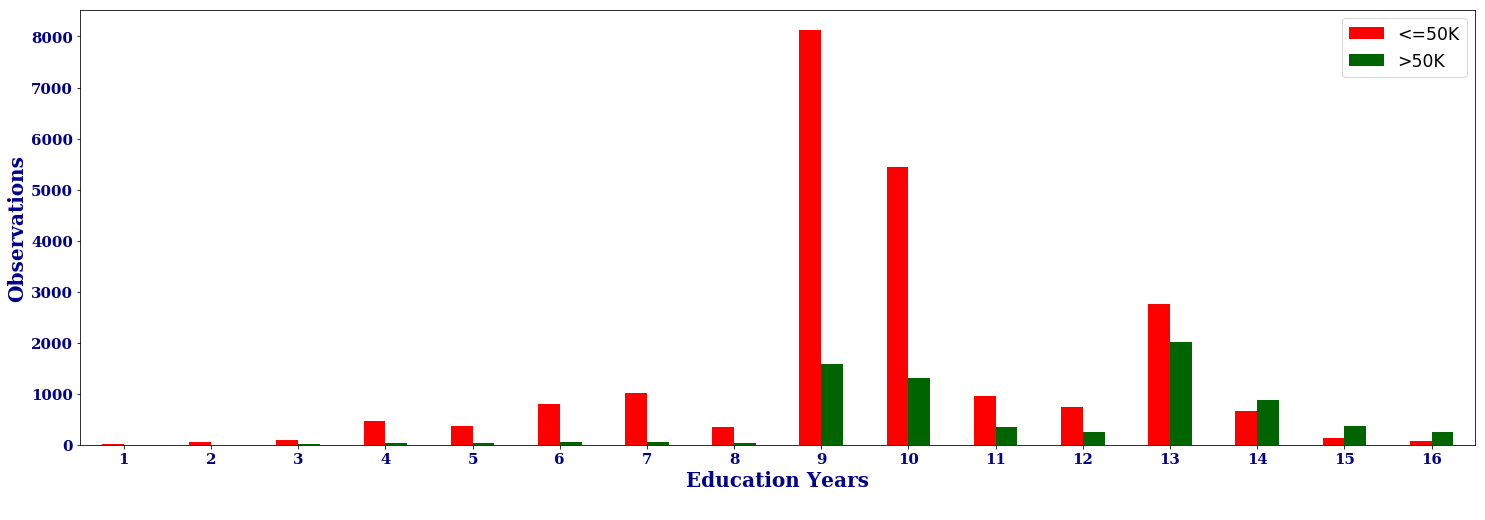

Level,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Name,Preschool,1st-4th,5th-6th,7th-8th,9th,10th,11th,12th,HS-grad,Some-college,Assoc-voc,Assoc-acdm,Bachelors,Masters,Prof-school,Doctorate


$ \\ $

$ \color{darkblue} {\textbf {About 90% of the observations are from US citizens. With 75% earning an income below \$50K and only 25% make more than \$50K.} } $

$ \color{darkblue} {\textbf {The population with only High School degree represent majority of people with income below \$50K.} } $

$ \color{darkblue} {\textbf {Although, individuals with Bachelors Degree have the most observations earning more than \$50K, more } } $

$ \color{darkblue} {\textbf {people in this group earn less than \$50K.} } $

$ \\ $

$ \color{darkblue} {\textbf {The top three highest paid occupations with only High School degree are: } }$

$ \color{darkgreen} {\;\; \textbf {1. Craft-repair} } $

$ \color{darkgreen} {\;\; \textbf {2. Exec-managerial} } $

$ \color{darkgreen} {\;\; \textbf {3. Sales} } $

$ \\ $

$ \color{darkblue} {\textbf {The top three highest paid occupations with Bachelors degree are: } }$

$ \color{darkgreen} {\;\; \textbf {1. Exec-managerial} } $

$ \color{darkgreen} {\;\; \textbf {2. Prof-specialty} } $

$ \color{darkgreen} {\;\; \textbf {3. Sales} } $

$ \\ $

$ \color{darkblue} {\textbf {Further investigation can be done by anlyzing how features correlated to education correlate to income.} } $

In [32]:
display(incomeUSA)
display((eduIncomeUSA.sort_values(by = '<=50K', ascending = False)[0:5].T))
display(eduIncomeUSA.T)

_ = eduIncomeUSA.plot(figsize = (25,8), kind='bar', color = ['red', 'darkgreen'])
_ = plt.xticks(rotation = 0, size = 15, color = 'darkblue', fontname = 'serif', fontweight = 'bold')
_ = plt.xlabel('Education Years\n', size = 20, fontname = 'serif', color = 'darkblue', fontweight = 'bold')
_ = plt.yticks(size = 15, color = 'darkblue', fontname = 'serif', fontweight = 'bold')
_ = plt.ylabel('Observations', size = 20, fontname = 'serif', color = 'darkblue', fontweight = 'bold')
_ = plt.legend(fontsize = 'xx-large')
_ = plt.show()
# display ref table
display(eduRef)
# display text
display(Markdown(r'$ \\ $'), \
        Markdown(r'$ \color{darkblue} {\textbf {About 90% of the observations are from US citizens. With 75% earning an income below \$50K and only 25% make more than \$50K.} } $'))
display(Markdown(r'$ \color{darkblue} {\textbf {The population with only High School degree represent majority of people with income below \$50K.} } $'))
display(Markdown(r'$ \color{darkblue} {\textbf {Although, individuals with Bachelors Degree have the most observations earning more than \$50K, more } } $'))
display(Markdown(r'$ \color{darkblue} {\textbf {people in this group earn less than \$50K.} } $'))
display(Markdown(r'$ \\ $'), \
        Markdown(r'$ \color{darkblue} {\textbf {The top three highest paid occupations with only High School degree are: } }$'))
display(Markdown(r'$ \color{darkgreen} {\;\; \textbf {1. Craft-repair} } $'))
display(Markdown(r'$ \color{darkgreen} {\;\; \textbf {2. Exec-managerial} } $'))
display(Markdown(r'$ \color{darkgreen} {\;\; \textbf {3. Sales} } $'))
display(Markdown(r'$ \\ $'), \
        Markdown(r'$ \color{darkblue} {\textbf {The top three highest paid occupations with Bachelors degree are: } }$'))
display(Markdown(r'$ \color{darkgreen} {\;\; \textbf {1. Exec-managerial} } $'))
display(Markdown(r'$ \color{darkgreen} {\;\; \textbf {2. Prof-specialty} } $'))
display(Markdown(r'$ \color{darkgreen} {\;\; \textbf {3. Sales} } $'))                 
display(Markdown(r'$ \\ $'), \
        Markdown(r'$ \color{darkblue} {\textbf {Further investigation can be done by anlyzing how features correlated to education correlate to income.} } $'))

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Model Analysis} $

***
</span>
</div>

### <span style = 'color:darkblue'> $ \textrm {Model Training/Fitting on All Features} $ </span>
<span style = 'color:darkblue'> $ \textrm {In this analysis, four models are applied to pre-processed data and compared for best performance based on accurracy and precision.} $ <br> $ \textrm {Selected models are: } $ </span>
> <span style = 'color:darkblue'> $ \textrm {1. Linear Regression} $ <br>
> <span style = 'color:darkblue'> $ \textrm {2. Logistic Regression} $ <br>
> <span style = 'color:darkblue'> $ \textrm {3. Decision Tree Regressor} $ <br>
> <span style = 'color:darkblue'> $ \textrm {4. Random Forest Classifier} $

In [33]:
confM_list = []
modelCoef = []
tbl_df = pd.DataFrame()
tbl = pd.DataFrame()
confM_col = ['TP','FP','FN','TN']
confM = pd.DataFrame(columns = confM_col)
ScoreBrd = pd.DataFrame()


# Model specific parameters
# Set max_depth for Decision Tree and n_estimators Random Forest regression
DT_maxDepth= 5
RFC_estCount = 10

# list of models to use for Analysis
AnalysisModels = {'Linear Regression': linear_model.LinearRegression(fit_intercept = True, \
                                                                     normalize = False),
                 'Logistic Regression': linear_model.LogisticRegression(class_weight= 'balanced', \
                                                                        solver='liblinear'),
                 'Decision Tree Regressor': DecisionTreeRegressor(max_depth=DT_maxDepth, \
                                                                  max_features = featureCount),
                 'Random Forest Classifier': RandomForestClassifier(n_estimators=RFC_estCount, \
                                                                    bootstrap = True)}
XY_sets = [[X_train_data, Y_train_data, 'Train_'], [X_test_data, Y_test_data, 'Test_']]

for X, Y, prfx in XY_sets:
    # Initialization
    lst = []
    Y_prd_data = []
    Y_prd_proba_data = []
    modelScore = []
    ScoreBoard = pd.DataFrame()
    ScoreBrdLst = []
    
    # Create normalized linear regression object
    for name, model in AnalysisModels.items():
        ScoreBoard = pd.DataFrame()
        #print('Model: ', name)
        # Train the model using the training sets
        model.fit(X_train_data, Y_train_data)
 
        # Make predictions using the testing set
        prd = np.array(model.predict(X))

        if prfx == 'Test_':
            # store model feature coefficients
            if name == list(AnalysisModels)[0] or name == list(AnalysisModels)[1]:
                modelCoef.append(model.coef_.round(decimals).tolist()[0])
            else:
                modelCoef.append(model.feature_importances_.round(decimals).tolist())

        if name == list(AnalysisModels)[0]:
            # post-processing - convert predicted values from linear Regression to list format
            [lst.append(i[0]) for i in prd]
            Y_prd_data.append(lst)
            prd = lst

            if prfx == 'Test_':
                # The coefficients for linear regression
                r_coeff = model.coef_.round(decimals)

        else:
            Y_prd_data.append(prd)

        # use predict probability for models   
        if hasattr(model, 'predict_proba'):
            prd_proba = model.predict_proba(X)[:,1]
            Y_prd_proba_data.append(np.array(prd_proba))

            # Generate confusion matrix
            c_ary, c_mtx = ConfMtx(Y[target_column_name].values.tolist(), prd_proba)
            confM_list.append(c_ary)
            ScoreBrdLst.append(ConfMtx_Scoreboard(Y[target_column_name].values.tolist(), prd_proba))

        else:
            # Append empty list 
            Y_prd_proba_data.append([])

            # Generate confusion matrix
            c_ary, c_mtx = ConfMtx(Y[target_column_name].values.tolist(), prd)
            confM_list.append(c_ary)
            ScoreBrdLst.append(ConfMtx_Scoreboard(Y[target_column_name].values.tolist(), prd))

        # Get Model performance score
        modelScore.append(round(model.score(X, Y), decimals))

    # Compose formated table
    table = pd.DataFrame(list(zip(list(AnalysisModels), modelScore)), columns = ['Model', 'Model-Score']).set_index('Model').add_prefix(prfx)

    if tbl_df.shape[0] == 0: 
        tbl_df = tbl_df.append(table, sort = False)
    else:
        tbl_df = tbl_df.join(table)

    ScoreBoard = pd.DataFrame(ScoreBrdLst, \
                              columns = ['TP', 'FP', 'FN','TN', \
                                         'Recall', 'Specificity', 'Accuracy', 'Precision', \
                                         'Sensitivity', 'F-Score', 'Error Rate']).add_prefix(prfx)
    if ScoreBrd.shape[0] == 0: 
        ScoreBrd = ScoreBrd.append(ScoreBoard, sort = False)
    else:
        ScoreBrd = ScoreBrd.join(ScoreBoard)

# Set ScoreBrd index to correxponding models as in model score tabel, tbl_df
ScoreBrd.index = tbl_df.index

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [34]:
# Rearrange columns to pair up test and train data
col = ScoreBrd.columns
colum = []
offset = np.int(len(col)/2)
for i in range(offset):
    colum = np.append(colum, [col[i], col[i+offset]])

ScoreBrd = ScoreBrd[colum]

***
## <span style = 'color:darkblue'> <center> $ \textrm {Model Evaluation } $

Model,Linear Regression,Logistic Regression,Decision Tree Regressor,Random Forest Classifier
Train_Model-Score,0.36,0.81,0.42,0.99
Test_Model-Score,0.37,0.86,0.49,0.89


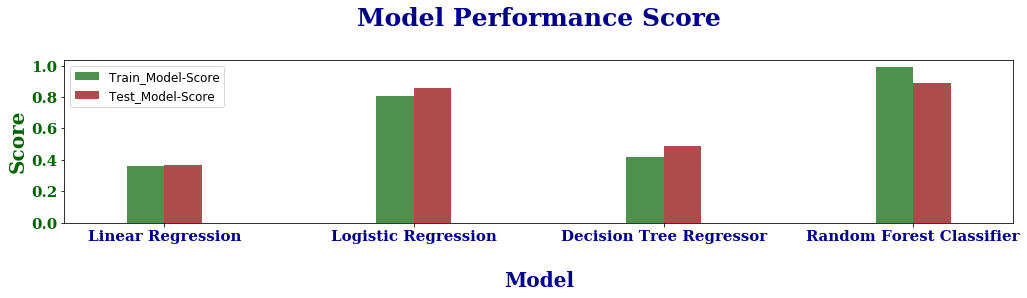

In [35]:
display(tbl_df.T)
# plot the model score
_ = tbl_df.plot(kind = 'bar', figsize = (17,3), color = ['darkgreen', 'darkred'], width = .3, alpha = 0.7)
_ = plt.title('Model Performance Score\n', color = 'darkblue', fontweight = 'bold', size = 25, fontname = 'serif')
_ = plt.xlabel('\nModel', size = 20, color = 'darkblue', fontweight = 'bold', fontname = 'serif')
_ = plt.ylabel('Score', size = 20, color = 'darkgreen', fontweight = 'bold', fontname = 'serif')
_ = plt.xticks(rotation = 0, size = 15, color ='darkblue', fontweight = 'bold', fontname = 'serif')
_ = plt.yticks(size = 15, color ='darkgreen', fontweight = 'bold', fontname = 'serif')
_ = plt.legend(fontsize = 'large')
_ = plt.show()

In [36]:
MScoreBoard = ScoreBrd.join(tbl_df).T

<ul></ul><center>$ \color{darkblue} {\Large {\textrm {Model Confusion Matrix Analysis}} \\} $

Model,Linear Regression,Logistic Regression,Decision Tree Regressor,Random Forest Classifier
Train_TP,23261.0000,19610.0000,23520.0000,24631.0000
Test_TP,40.0000,36.0000,40.0000,40.0000
Train_FP,1418.0000,5069.0000,1159.0000,48.0000
Test_FP,1.0000,5.0000,1.0000,1.0000
Train_FN,3748.0000,1212.0000,3648.0000,339.0000
Test_FN,8.0000,3.0000,8.0000,5.0000
Train_TN,4078.0000,6614.0000,4178.0000,7487.0000
Test_TN,7.0000,12.0000,7.0000,10.0000
Train_Recall,0.5211,0.8451,0.5339,0.9567
Test_Recall,0.4667,0.8000,0.4667,0.6667


$ \\ $

$ \color{darkblue} {\textrm {Logistic Regression Model offers overall best evaluation based on Model-Score and  F-Score.}} $

$ \\ $

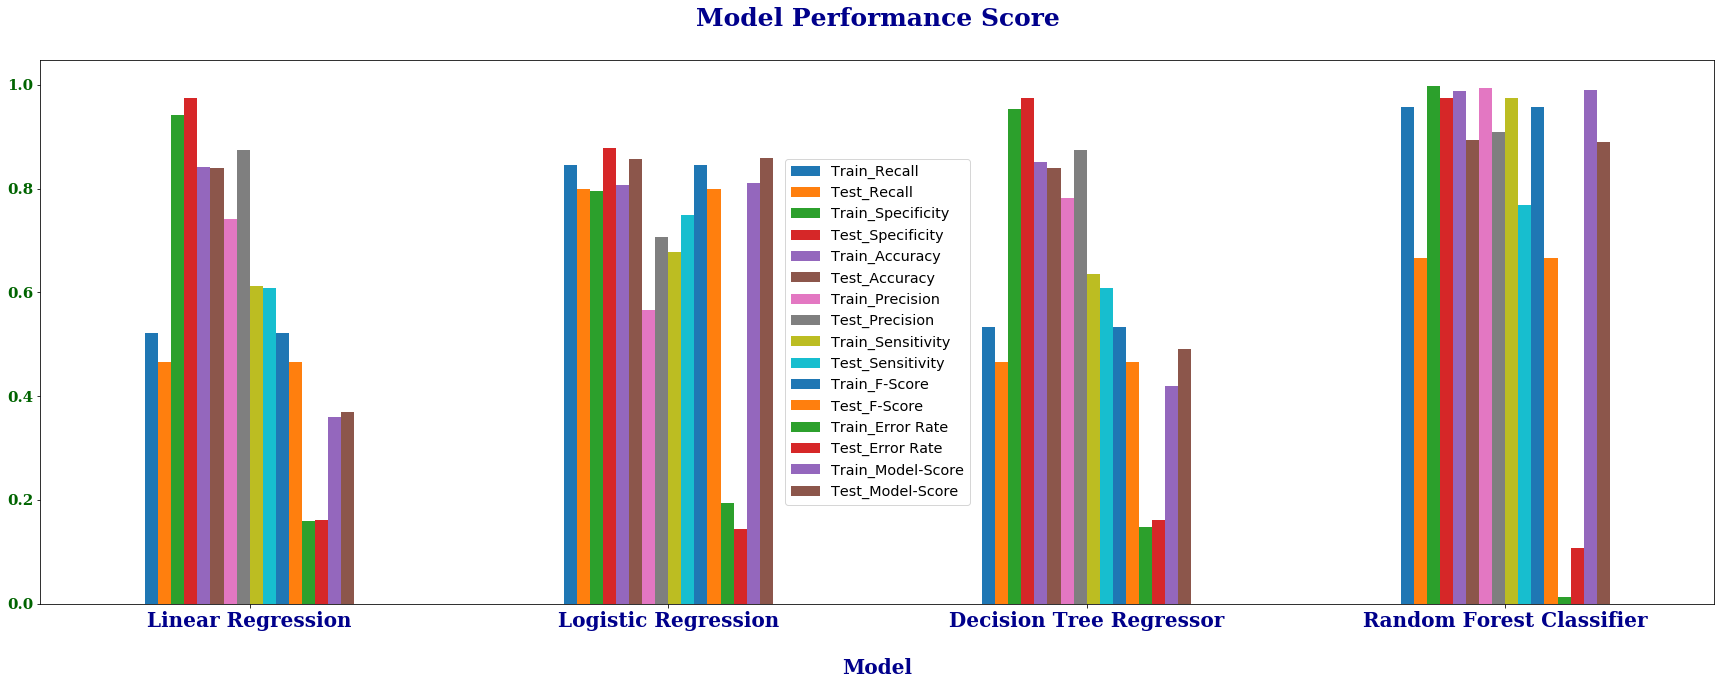

In [37]:
display(Markdown( r'<ul></ul><center>$ \color{darkblue} {\Large {\textrm {Model Confusion Matrix Analysis}} \\} $'),\
        MScoreBoard, \
        Markdown( r'$ \\ $'), \
        Markdown( r'$ \color{darkblue} {\textrm {Logistic Regression Model offers overall best evaluation based on Model-Score and  F-Score.}} $'), \
        Markdown( r'$ \\ $') )
_ = MScoreBoard[8:24].T.plot.bar(figsize = (30,10))
_ = plt.title('Model Performance Score\n', color = 'darkblue', fontweight = 'bold', size = 25, fontname = 'serif')
_ = plt.xlabel('\nModel', size = 20, color = 'darkblue', fontweight = 'bold', fontname = 'serif')
_ = plt.xticks(rotation = 0, size = 20, color ='darkblue', fontweight = 'bold', fontname = 'serif')
_ = plt.yticks(size = 15, color ='darkgreen', fontweight = 'bold', fontname = 'serif')
_ = plt.legend(fontsize = 'x-large', loc = 'center')

***
## <span style = 'color:darkblue'> <center> $ \textrm {Visual Analysis of Model Comparison } \\ $ <center> $\textrm { Truth vs Predicted} $

## ROC - AUC Analysis

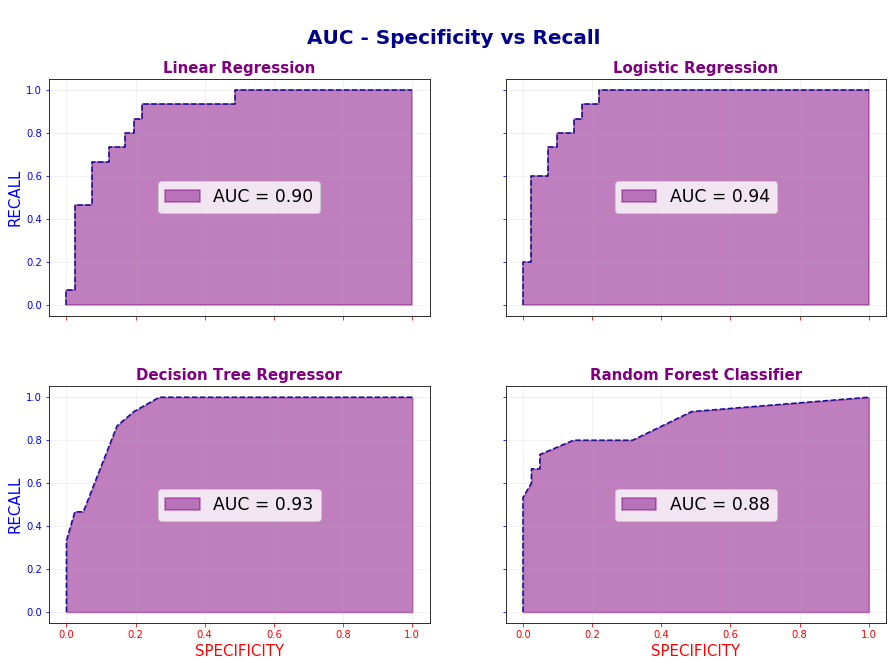

In [38]:
idx=0
#create 2 rows, 2 columns, sharing x axis, hide horizontal space inbetween
fig, axis = plt.subplots(2,2, sharex = 'col', sharey= 'row', figsize=[15,10])
_ = fig.suptitle('\nAUC - Specificity vs Recall\n\n', size = 20, color = 'darkblue',fontweight='bold')
for axs in axis.flat:
    # calculate AUC for each model
    if hasattr(list(AnalysisModels.values())[idx], 'predict_proba'):
        Specificity, Recall, Thresholds, ROC_AUC = GetROC_AUC(Y_test_data, Y_prd_proba_data[idx])
    else:
        Specificity, Recall, Thresholds, ROC_AUC = GetROC_AUC(Y_test_data, Y_prd_data[idx])
    
    # plot AUC curve for corresponding Model
    axs.plot(Specificity, Recall, lw=1.5, alpha=0.9, color='darkblue', linestyle='--')
    axs.fill_between(Specificity, Recall, lw=1.5, alpha=0.5, label='AUC = %0.2f' % ROC_AUC , color='purple')
    axs.set_title(list(AnalysisModels)[idx],\
                  size = 15, fontweight='bold', color='purple')
    if idx == 2 or idx == 3:
        axs.set_xlabel('SPECIFICITY', color = 'r', size = 15)
    if idx == 0 or idx == 2:
        axs.set_ylabel('RECALL', color = 'b', size = 15)
    axs.tick_params(axis='x', color='r', labelcolor='r')
    axs.tick_params(axis='y', color='b', labelcolor='b')
    axs.legend(loc='center', fontsize='xx-large')
    axs.grid(alpha=0.2)
    idx+=1
    
# adjust horizontal spae 
_ = fig.subplots_adjust(hspace = 0.3)
plt.show()

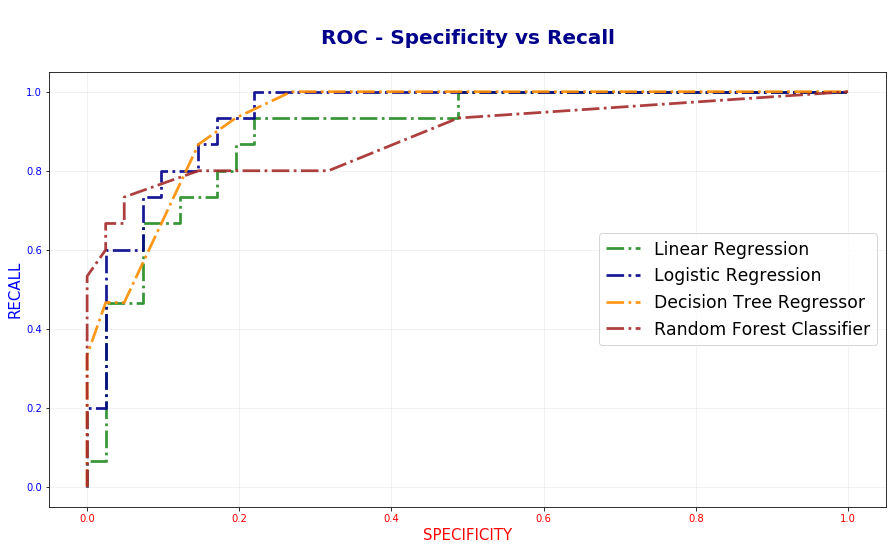

<center>$ \color{darkblue} {\large {\textrm {Logistic Regression with a slight advantage over Decision Tree Regressor is the best performing model}} }$

In [39]:
idx=0
m_colors = ['forestgreen', 'darkblue', 'darkorange', 'brown']
_ = plt.figure(figsize = [15,8])
for model in AnalysisModels:
    # calculate ROC for each model
    if hasattr(list(AnalysisModels.values())[idx], 'predict_proba'):
        Specificity, Recall, Thresholds = roc_curve(Y_test_data, Y_prd_proba_data[idx])
    else:
        Specificity, Recall, Thresholds = roc_curve(Y_test_data, Y_prd_data[idx])
    # plot AUC curve for corresponding Model
    plt.plot(Specificity, Recall, lw=2.75, alpha=0.9, label= list(AnalysisModels)[idx], \
             color=m_colors[idx], linestyle = '-.')
    idx+=1

_ = plt.title('\nROC - Specificity vs Recall\n', size = 20, color = 'darkblue',fontweight='bold')
_ = plt.xlabel('SPECIFICITY', color = 'r', size = 15)
_ = plt.ylabel('RECALL', color = 'b', size = 15)
_ = plt.xticks(color = 'r')
_ = plt.yticks(color = 'b')
_ = plt.legend(loc='center right', fontsize='xx-large')
_ = plt.grid(alpha=0.2)
_ = plt.show()
display(Markdown(r'<center>$ \color{darkblue} {\large {\textrm {Logistic Regression with a slight advantage over Decision Tree Regressor is the best performing model}} }$' ))
print('\n')

<div class="span5 alert alert-success">
    
***
<center> $ \color{darkblue} { \Large { \textrm {Feature Analysis} } }$
<ul></ul>
<center> $ \Large {\textrm {Identify and rank features affecting adult income} } $

***
</span>
</div>

$ \\ $ <center> $\color{darkblue} {\large {\textbf {Feature Coefficient Ranking} }} $

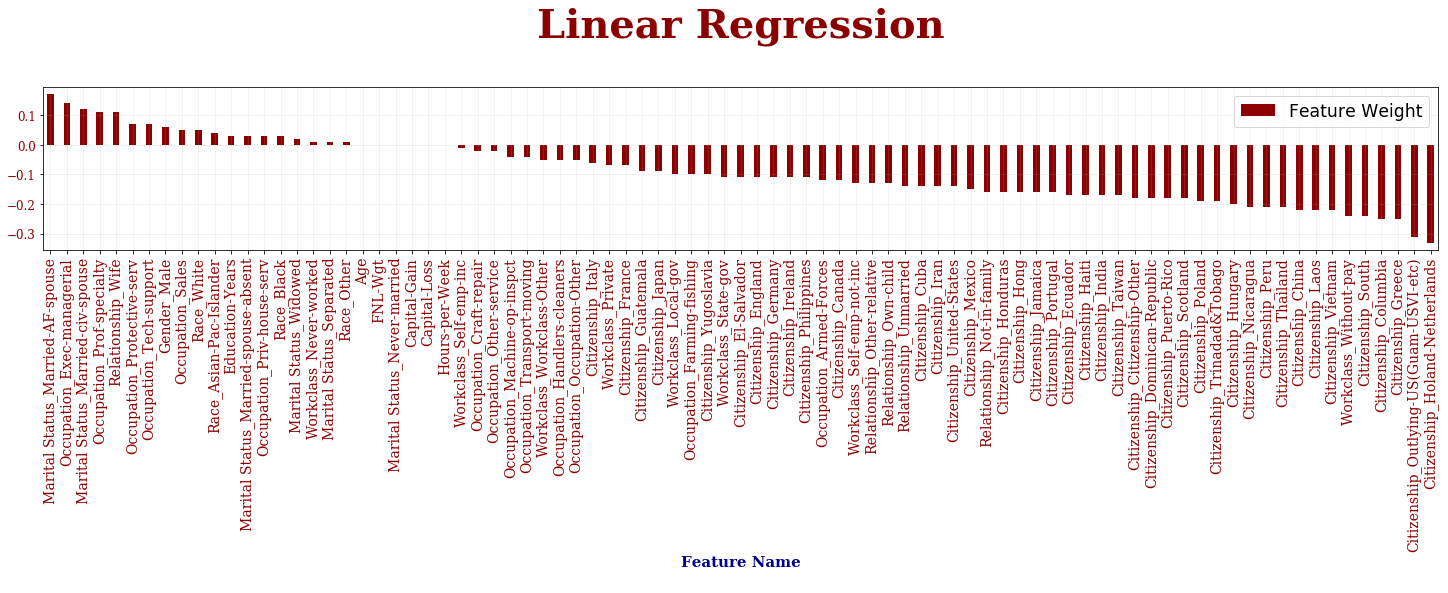

$\color {darkblue} {\textbf {Most Positively Ranked Features}} $

Feature Name,Marital Status_Married-AF-spouse,Occupation_Exec-managerial,Marital Status_Married-civ-spouse,Occupation_Prof-specialty,Relationship_Wife,Occupation_Protective-serv,Occupation_Tech-support,Gender_Male
Feature Weight,0.17,0.14,0.12,0.11,0.11,0.07,0.07,0.06


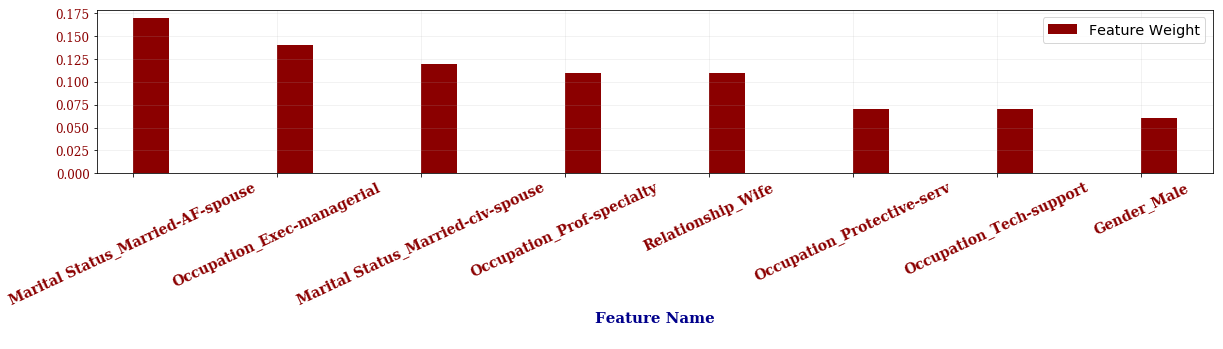

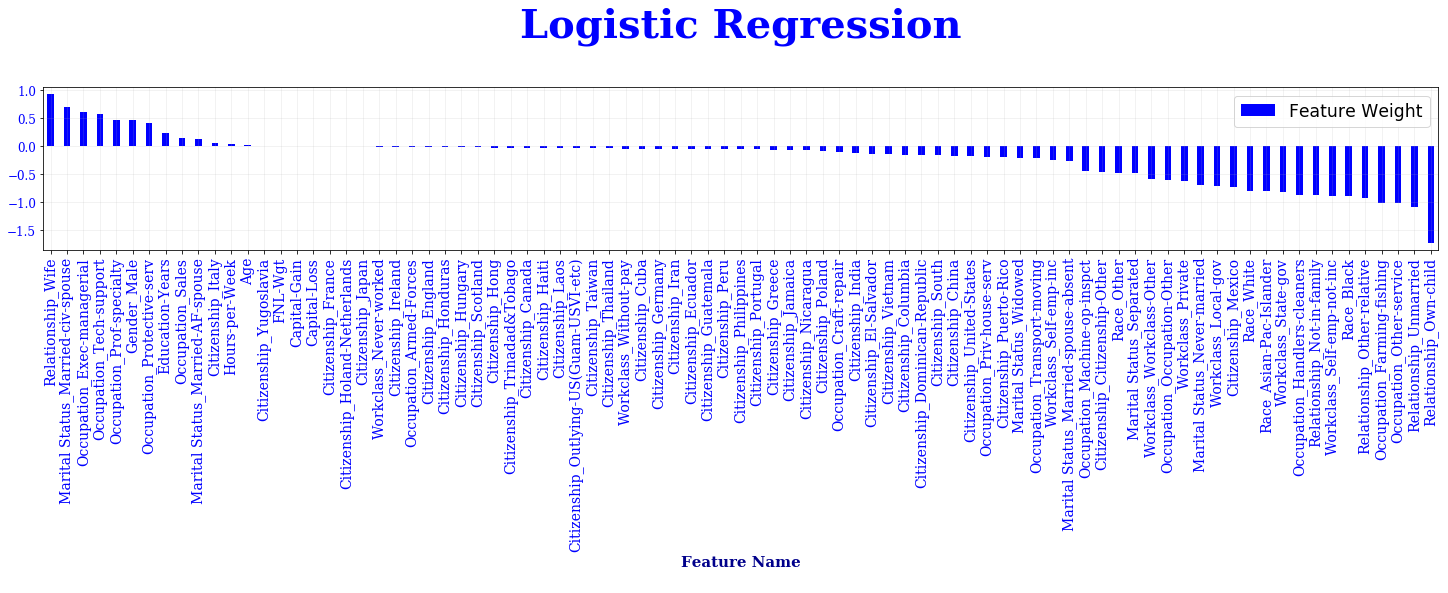

$\color {darkblue} {\textbf {Most Positively Ranked Features}} $

Feature Name,Relationship_Wife,Marital Status_Married-civ-spouse,Occupation_Exec-managerial,Occupation_Tech-support,Occupation_Prof-specialty,Gender_Male,Occupation_Protective-serv,Education-Years
Feature Weight,0.93,0.7,0.61,0.58,0.47,0.47,0.41,0.23


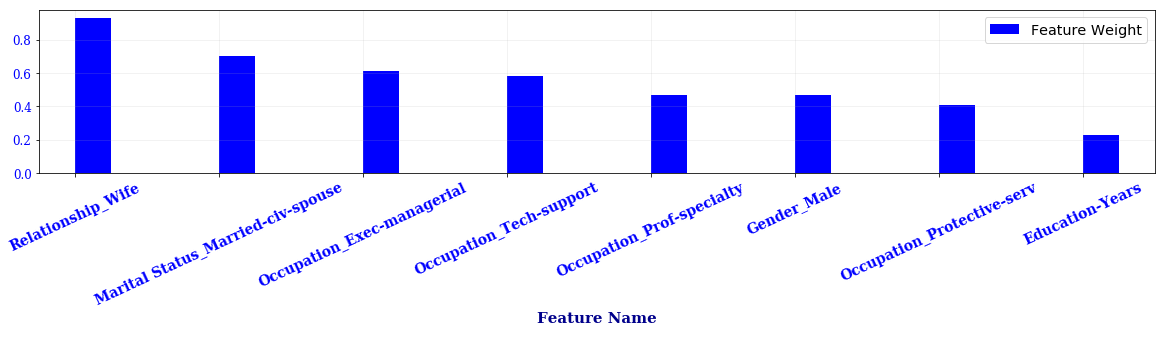

$\color {darkblue} {\textbf {Most Negatively Ranked Features}} $

Feature Name,Workclass_Self-emp-not-inc,Race_Black,Relationship_Other-relative,Occupation_Farming-fishing,Occupation_Other-service,Relationship_Unmarried,Relationship_Own-child
Feature Weight,-0.89,-0.89,-0.93,-1.02,-1.02,-1.1,-1.73


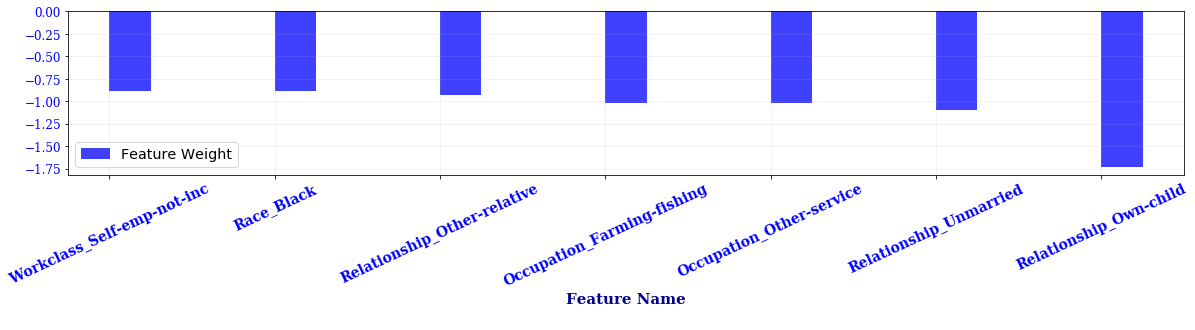

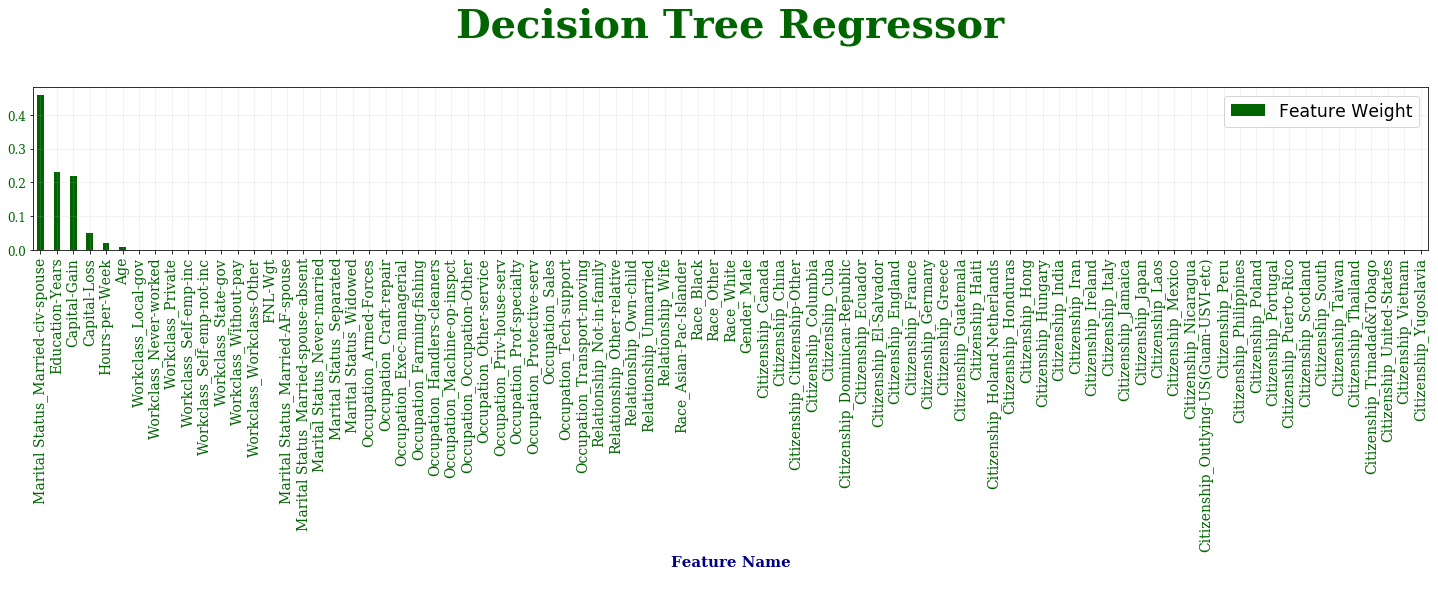

$\color {darkblue} {\textbf {Most Positively Ranked Features}} $

Feature Name,Marital Status_Married-civ-spouse,Education-Years,Capital-Gain,Capital-Loss,Hours-per-Week,Age,Workclass_Local-gov,Workclass_Never-worked
Feature Weight,0.46,0.23,0.22,0.05,0.02,0.01,0.0,0.0


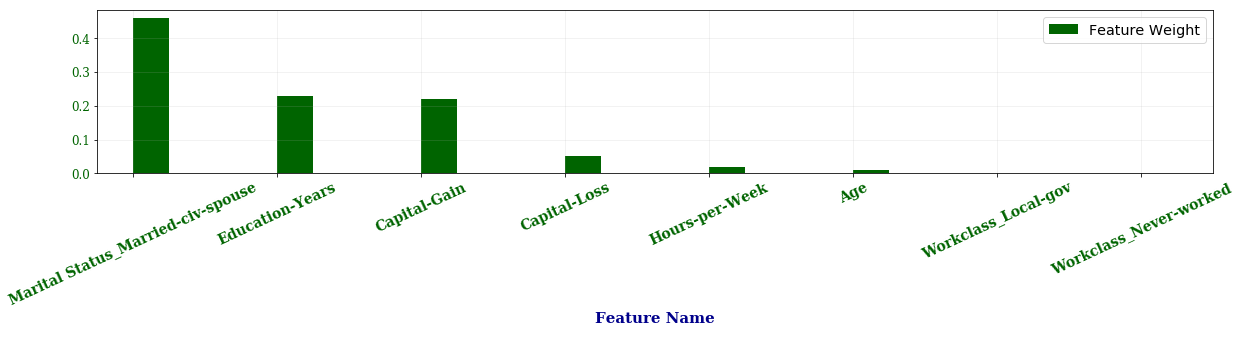

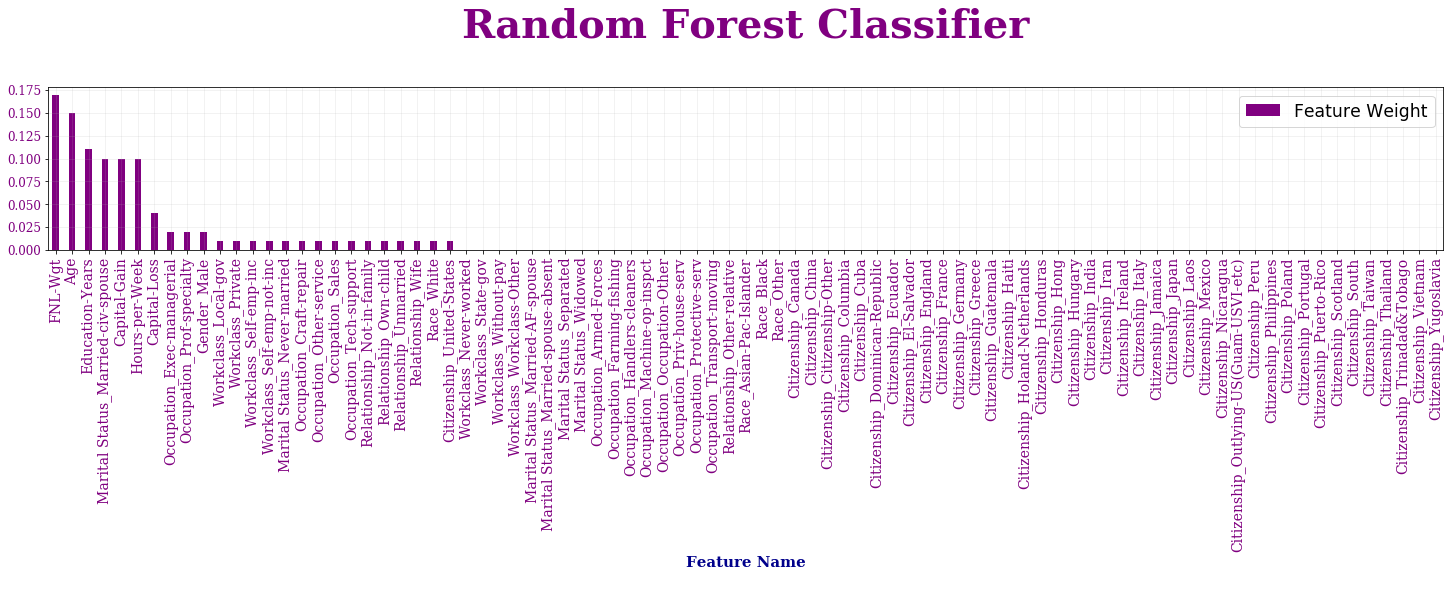

$\color {darkblue} {\textbf {Most Positively Ranked Features}} $

Feature Name,FNL-Wgt,Age,Education-Years,Marital Status_Married-civ-spouse,Capital-Gain,Hours-per-Week,Capital-Loss,Occupation_Exec-managerial
Feature Weight,0.17,0.15,0.11,0.1,0.1,0.1,0.04,0.02


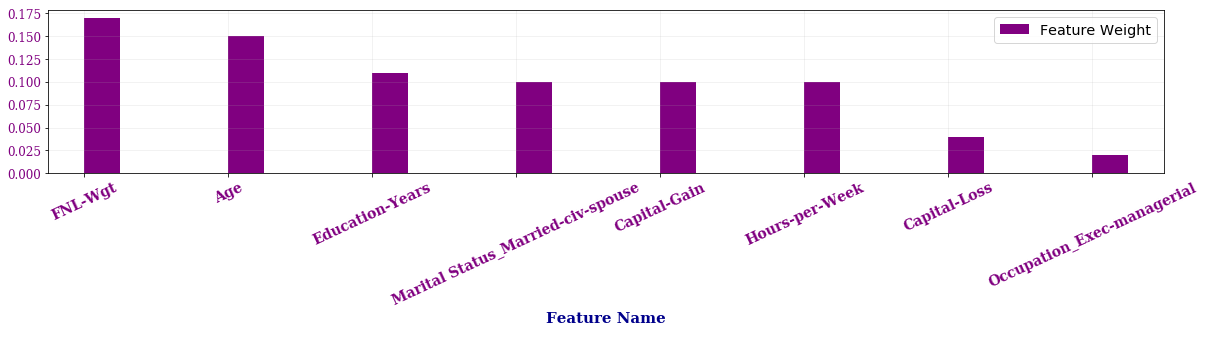

In [40]:
c = ['darkred','b', 'darkgreen','purple']
display(Markdown(r'$ \\ $ <center> $\color{darkblue} {\large {\textbf {Feature Coefficient Ranking} }} $'))
csfont = {'fontname':'Comic Sans MS'}
for m_coef in modelCoef:
    # get element index in current iteration
    idx = modelCoef.index(m_coef)

    # Linear and Logistic regression have coef_ attribute calculating weight of features
    # Decision Regressor and Random Forest Classifer have importance_ attribute calculating weight of features    
    feat_Weight = dict(zip(feature_column_names, m_coef))
    featureWeight = pd.DataFrame(sorted(feat_Weight.items(), \
                                        key = operator.itemgetter(1), \
                                        reverse = True), \
                                 columns = ['Feature Name', \
                                            'Feature Weight']).set_index('Feature Name')
    
    _ = featureWeight.plot.bar(figsize= [25, 3], color = c[idx], \
                               align = 'center', width = 0.4)
    _ = plt.title(list(AnalysisModels)[idx]+'\n', size = 40, fontname = 'Serif', color = c[idx],\
                  fontweight='bold')
    _ = plt.xlabel('Feature Name\n', size = 15, fontname = 'serif', color = 'darkblue', fontweight = 'bold')
    _ = plt.xticks(color = c[idx], size=14, fontname = 'serif')
    _ = plt.yticks(color = c[idx], size=12, fontname = 'serif')
    _ = plt.grid(alpha = 0.2)
    _ = plt.legend(fontsize='xx-large')
    _ = plt.show()
    display(Markdown(r'$\color {darkblue} {\textbf {Most Positively Ranked Features}} $'), \
            featureWeight[0:8].T)

    _ = featureWeight[0:8].plot.bar(figsize= [20, 3], color = c[idx], align = 'edge', width = 0.25)
    _ = plt.xlabel('Feature Name\n', size = 15, fontname = 'serif', color = 'darkblue', fontweight = 'bold')
    _ = plt.xticks(rotation = 25, color = c[idx], size=14, fontname = 'serif', fontweight = 'bold')
    _ = plt.yticks(color = c[idx], size=12, fontname = 'serif')
    _ = plt.grid(alpha = 0.2)
    _ = plt.legend(fontsize='x-large')
    _ = plt.show()
    if idx == 1:
        display(Markdown(r'$\color {darkblue} {\textbf {Most Negatively Ranked Features}} $'), \
                featureWeight[-7:].T)

        _ = featureWeight[-7:].plot.bar(figsize= [20, 3], color = c[idx], align = 'edge', width = 0.25, alpha = 0.75)
        _ = plt.xlabel('Feature Name\n', size = 15, fontname = 'serif', color = 'darkblue', fontweight = 'bold')
        _ = plt.xticks(rotation = 25, color = c[idx], size=14, fontname = 'serif', fontweight = 'bold')
        _ = plt.yticks(color = c[idx], size=12, fontname = 'serif')
        _ = plt.grid(alpha = 0.2)
        _ = plt.legend(fontsize='x-large')

<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Feature Selection/Reduction Analysis} $

***
</span>
</div>

In [41]:
coeffList = r_coeff.tolist()[0]
# Create a sorted dictionary of features and coefficients from linear regression analysis
LR_FeatureCoefficient = dict(zip(feature_column_names, coeffList))

feature_df = pd.DataFrame(sorted(LR_FeatureCoefficient.items(), \
                                 key=operator.itemgetter(1), reverse = True), \
                          columns = ['Feature Name', \
                                     'Feature Coefficient']).set_index('Feature Name')

# Display 10 highest and lowest features
feat_df = feature_df[0:5].append(feature_df[-5:])
display(Markdown(r'$ \\ $ <center> $\color {darkblue} {\large {\textbf {Linear Regression Feature Coefficient Ranking} }} $'))
display(Markdown(r'$\color {darkblue} {\textbf {Ten Features with highest and lowest Coefficients:}}$'), \
        feat_df)
display(Markdown(r'<ul></ul>$\color {darkblue} {\textbf {Highest and lowest coefficients respectively indicate the feature affecting model performance predicting the target.}}$'))

$ \\ $ <center> $\color {darkblue} {\large {\textbf {Linear Regression Feature Coefficient Ranking} }} $

$\color {darkblue} {\textbf {Ten Features with highest and lowest Coefficients:}}$

,Feature Coefficient
Feature Name,
Marital Status_Married-AF-spouse,0.17
Occupation_Exec-managerial,0.14
Marital Status_Married-civ-spouse,0.12
Occupation_Prof-specialty,0.11
Relationship_Wife,0.11
Citizenship_South,-0.24
Citizenship_Columbia,-0.25
Citizenship_Greece,-0.25
Citizenship_Outlying-US(Guam-USVI-etc),-0.31


<ul></ul>$\color {darkblue} {\textbf {Highest and lowest coefficients respectively indicate the feature affecting model performance predicting the target.}}$

$ \\ $ <center> $\color{darkblue} {\large {\textbf {Forest Classifier Feature Coefficient Ranking} }} $

$\color {darkblue} {\textbf {Ten highest Ranked Features}} $

,Feature Weight
Feature Name,
Workclass_Local-gov,0.1796
Workclass_Self-emp-not-inc,0.1216
Age,0.0806
Workclass_Never-worked,0.0667
Workclass_Self-emp-inc,0.0622
Workclass_State-gov,0.0298
Workclass_Private,0.0189
Workclass_Workclass-Other,0.0063


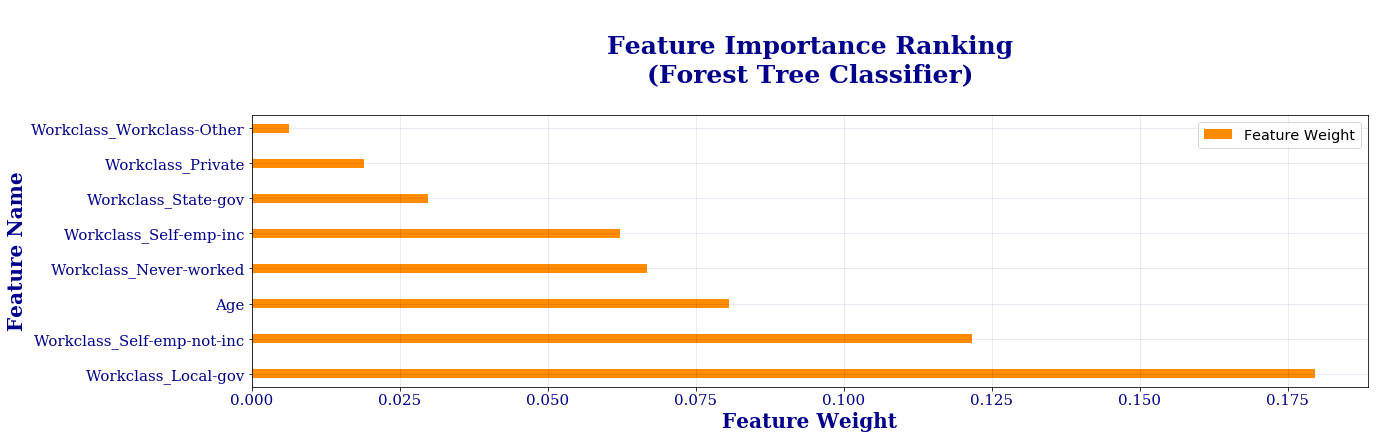

In [42]:
# informative features count
informative = 5
# repeated features count
repeated = 0

# Build a classification task using 3 informative features
X, y = make_classification(n_samples = adultIncome_df.shape[0],
                           n_features = featureCount,
                           n_informative = informative,
                           n_repeated = repeated,
                           n_classes = 2,
                           random_state = 0,
                           shuffle = False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators = RFC_estCount,
                              random_state = 0)
forest.fit(X, y)
importances = np.round(forest.feature_importances_, 4)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Create 1-d list of feature names corresponding to indices
featureNames = [feature_column_names[i] for i in indices]
# Create 1-d list of feature weightss corresponding to indices
featureWeight = [importances[i] for i in indices]
informative_features = [informative for i in indices]
featuresUsed = [featureCount for i in indices]
featuresRepeated = [repeated for i in indices]
# Concatenate lists and transpose to get columns
RankCollection = (np.concatenate(([range(1,featureCount+1,1)], [featureNames], \
                              [indices],[featureWeight], [informative_features], \
                             [featuresRepeated]), \
                             axis=0)).T
rank_df = pd.DataFrame(RankCollection, columns=['Rank', 'Feature Name', 'Feature ID',\
                                            'Feature Weight', 'Feature Count', 'Informative Features'])
rank_df.drop(['Feature ID', 'Feature Count', 'Informative Features'], axis = 1, inplace = True)
# Change the row indexing to Rank of the Features
rank_df.set_index('Rank', inplace = True)
#display(rank_df[0:8])

rankedFeature = rank_df[0:8].sort_values(by = 'Feature Weight', ascending = False)
rankedFeature['Feature Weight'] = rankedFeature['Feature Weight'].astype('float')
rankedFeature.set_index('Feature Name', inplace = True)
#rankedFeature.drop(['Index'], axis = 1, inplace = True)
display(Markdown(r'$ \\ $ <center> $\color{darkblue} {\large {\textbf {Forest Classifier Feature Coefficient Ranking} }} $'))
display(Markdown(r'$\color {darkblue} {\textbf {Ten highest Ranked Features}} $'), rankedFeature)


#Plot the feature importances of the forest
_ = rankedFeature.plot.barh(figsize = (20, 5), color = 'darkorange', align = 'center', width = 0.25, bottom = 0)
_ = plt.title('\nFeature Importance Ranking\n(Forest Tree Classifier)\n', \
          size = 25, fontweight = 'bold', fontname = 'serif', color = 'darkBlue')
_ = plt.xlabel('Feature Weight', size = 20, color = 'darkblue', fontname = 'serif', fontweight = 'bold')
_ = plt.xticks(rotation = 0, size = 15, color = 'darkblue', fontname = 'serif')
_ = plt.ylabel('Feature Name', size = 20, color = 'darkblue', fontname = 'serif', fontweight = 'bold')
_ = plt.yticks(size = 15, color = 'darkblue', fontname = 'serif')
_ = plt.grid(alpha = 0.1, color = 'darkblue')
_ = plt.legend(fontsize='x-large')
_ = plt.show()

In [43]:
rank_df = pd.DataFrame(columns=['Index', 'Feature Name', 'Feature ID',\
                                'Feature Weight', 'Feature Count', \
                                'Informative Features'])
# repeated features count
repeated = 0

for informative in range(2,11,1):
    # Build a classification task using 3 informative features
    X, y = make_classification(n_samples = adultIncome_df.shape[0],
                               n_features = featureCount-informative,
                               n_informative = informative,
                               n_repeated = repeated,
                               n_classes = 2,
                               random_state = 0,
                               shuffle = False)

    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators = RFC_estCount,
                                  random_state = 0)
    forest.fit(X, y)
    importances = np.round(forest.feature_importances_, 4)
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Create 1-d list of feature names corresponding to indices
    featureNames = [feature_column_names[i] for i in indices]
    # Create 1-d list of feature weightss corresponding to indices
    featureWeight = [importances[i] for i in indices]
    featuresUsed = [featureCount-informative for i in indices]
    featuresInformative = [informative for i in indices]

    featuresRepeated = [repeated for i in indices]
    RowIndex = [i for i in range(1,featureCount-informative+1,1)]

    # Concatenate lists and transpose to get columns
    collection = (np.concatenate(([RowIndex], \
                                  [featureNames], \
                                  [indices],[featureWeight], [featuresUsed], \
                                  [featuresInformative]), axis=0)).T
    
    #generate a table of indexed 
    rank_df = rank_df.append(pd.DataFrame(collection, columns=['Index', 'Feature Name', 'Feature ID',\
                                                               'Feature Weight', 'Feature Count', \
                                                               'Informative Features']), ignore_index = True, \
                             sort=False)
rank_df.sort_values(by=['Feature Weight'], ascending = False, inplace = True)
_ = rank_df.set_index('Index')

In [44]:
rankedFeature = rank_df[0:10].sort_values(by = 'Feature Weight', ascending = False)
rankedFeature['Feature Weight'] = rankedFeature['Feature Weight'].astype('float')
rankedFeature.set_index('Feature Name', inplace = True)
rankedFeature = pd.DataFrame(rankedFeature.groupby('Feature Name')['Feature Weight'].mean().sort_values(ascending = False))

In [45]:
#bestFeatures = pd.DataFrame(columns = ['Feature Name', 'Mean Weight'])
bf = []
temp = rank_df[0:30]
for i in set(temp['Feature Name']):
    t = list(pd.to_numeric(temp[temp['Feature Name'] == i]['Feature Weight'], downcast='float'))
    #if mean weight is less than 1% stop calsulation mean
    if np.mean(t) >= 0.001:
        bf.append(np.transpose([i, round(np.mean(t),4)]))    
TopFeatures = pd.DataFrame(bf, columns = ['Feature Name', 'Mean Weight']).set_index('Feature Name')
TopFeatures.sort_values(by = 'Mean Weight', ascending = False, inplace = True)

$ \\ $ <center> $\color{darkblue} {\large {\textbf {Forest Classifier Average Feature Coefficient Ranking} }} $

$\color{darkblue} {\large\textbf {Summary Table:}} $

$\color {darkblue} {\textbf {Ten Highest Ranked Average Feature Weight With Informative-Features Ranging from 2 to 10}} $

,Mean Weight
Feature Name,
Workclass_Local-gov,0.1575
Workclass_Self-emp-not-inc,0.1394
Workclass_Private,0.1205
Workclass_Never-worked,0.1072
Workclass_Self-emp-inc,0.0968
Age,0.0934
Workclass_Without-pay,0.0932
Workclass_State-gov,0.078
Workclass_Workclass-Other,0.0711


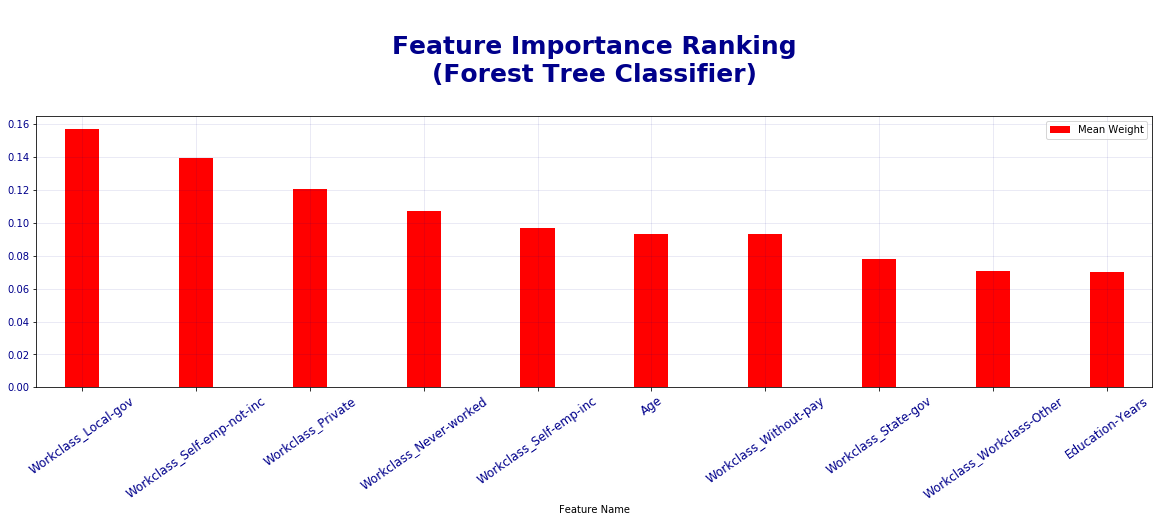

$\color{darkblue} {\textbf {Feature reduction analysis is appropriate when there is evidence of overfitting such as highly correlated features,} } $

$\color{darkblue} {\textbf {or when large number of features require excessive processing time and resources.} } $

$\color{darkblue} {\textbf {As established earlier, there are no evidence of overfitting affecting model selection and there are no computational challenges } } $

$\color{darkblue} {\textbf {due to feature count, therefore, applying feature reduction to the data is left for future exploration.} } $

In [46]:
display(Markdown(r'$ \\ $ <center> $\color{darkblue} {\large {\textbf {Forest Classifier Average Feature Coefficient Ranking} }} $'))
display(Markdown(r'$\color{darkblue} {\large\textbf {Summary Table:}} $'))
display(Markdown(r'$\color {darkblue} {\textbf {Ten Highest Ranked Average Feature Weight With Informative-Features Ranging from 2 to 10}} $'), \
        TopFeatures)

rankedFeature = TopFeatures.astype(float)
#Plot the feature importances of the forest
_ = rankedFeature.plot.bar(figsize= [20, 5], color = 'red', align = 'center', width = 0.3)
_ = plt.title('\nFeature Importance Ranking\n(Forest Tree Classifier)\n', \
              size = 25, fontweight = 'bold', color = 'darkBlue')
_ = plt.xticks(rotation = 35, size = 12, color = 'darkblue')
_ = plt.yticks(color = 'darkblue')
_ = plt.grid(alpha = 0.1, color = 'darkblue')
_ = plt.show()
print('\n')
display(Markdown(r'$\color{darkblue} {\textbf {Feature reduction analysis is appropriate when there is evidence of overfitting such as highly correlated features,} } $'))
display(Markdown(r'$\color{darkblue} {\textbf {or when large number of features require excessive processing time and resources.} } $'))
display(Markdown(r'$\color{darkblue} {\textbf {As established earlier, there are no evidence of overfitting affecting model selection and there are no computational challenges } } $'))
display(Markdown(r'$\color{darkblue} {\textbf {due to feature count, therefore, applying feature reduction to the data is left for future exploration.} } $'))


<div class="span5 alert alert-success">
    
***
# <span style = 'color:darkblue'> <center> $ \textrm {Conclusion} $

***
</span>
</div>

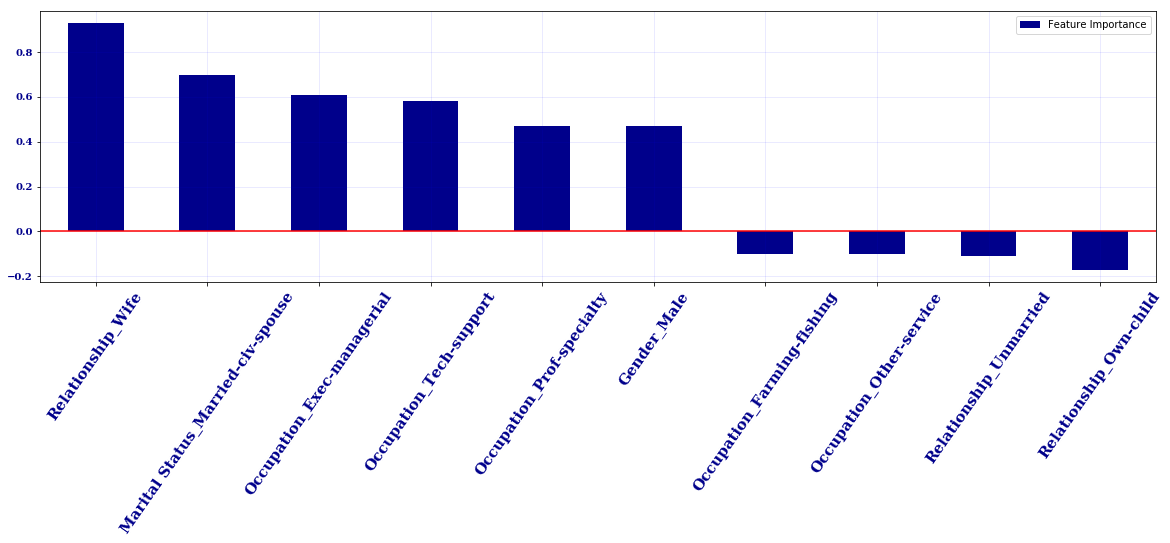

In [47]:
print('\n')
FeatImportance = pd.DataFrame(['0.93', '0.70', '0.61', '0.58', '0.47', '0.47','-0.102', '-0.102', '-0.110', '-0.173'], \
                     index = ['Relationship_Wife', 'Marital Status_Married-civ-spouse', \
                              'Occupation_Exec-managerial', 'Occupation_Tech-support', \
                              'Occupation_Prof-specialty', 'Gender_Male', \
                              'Occupation_Farming-fishing', 'Occupation_Other-service', \
                              'Relationship_Unmarried', 'Relationship_Own-child'],
                    columns = ['Feature Importance'])
_ = FeatImportance.astype(float).plot(kind = 'bar', figsize = (20,5), color = 'darkblue')
_ = plt.axhline(0, color = 'r')
_ = plt.xticks(rotation = 55, color = 'darkblue', fontname = 'serif', fontweight = 'bold', size = 15)
_ = plt.yticks(color = 'darkblue', fontname = 'serif', fontweight = 'bold')
_ = plt.grid(alpha = 0.1, color = 'b')
_ = plt.show()
print('\n')

### <span style='color:darkblue'> Each model performs differently in predicting the same dataset. Linear Regression highest feature coefficient is for 'Marital Status_Married-AF-spouse', Logistic Regression identifies 'Relationship_Wife' with highest coefficient, Decision Tree Regressor uses 'Marital Status_Married-civ-spouse' as the feature with highest coefficient, and finally, most important feature for Random Forest is 'FNL-Wgt'. 
    
### <span style='color:darkblue'> Considering Logistic Regression is the best performing model for this adult income analysis, the ten features with highest and lowest coefficients are presented in the plot above.

### <span style='color:darkblue'> Interestingly, relationship and occupation are present on both ends of the spectrum. While being married positively relates to income, in contrast, having children is presenting negative effect on income. This is consistent with expectation since it is financially, physically, and emotionally demanding to have children. Furthermore,'Relationship_Wife' implies observation was more likely received from a male participant. Although the feature 'Gender_Male' is positive for higher income, being male and married to a wife provides a better chance of higher earnings.

### <span style='color:darkblue'> As illustrated in the plot above, next highest contributor to income is occupation. Again, similar to relationship, occupation appears to be both positively and negatively related to income level. On the positive side, managerial and tech jobs contribute to higher income, while service and farming occupations are not accounted as profitable and drag on chances for higher income level. 